# **FEATURE ANALYSIS**
It is important that the features for both logistic and mini-forest algorithms are chosen wisely, in order to find the perfect match for each.

In this notebook, not only we are going to explore the different features we are provided with, but as we are provided with timeseries data, we are going to adapt it in order to make it fit in non time dependent algorithms.

First of all, we need to install the updated packages:

In [ ]:
# Update python packages.
!pip install numpy==1.20.3
!pip install pandas==1.3.1
!pip install scipy==1.7.1
!pip install matplotlib==3.4.2
!pip install seaborn==0.11.1
!pip install scikit-learn==0.24.2
!pip install mlxtend==0.18.0
!pip install xarray==0.19.0
!pip install sklearn-genetic
!pip install xgboost==1.4.0
!pip install lightgbm==3.2.1
!pip install jupyterlab==3.1.6

To import python modules from github, let's direct to my repository:

In [ ]:

!git clone https://github.com/sopechris/pipeline.git

fatal: destination path 'Data_Management' already exists and is not an empty directory.


Add imported directories to system path to import modules directly.

In [ ]:
import sys
sys.path.append('pipeline/')

Import python packages.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn.decomposition import PCA

Import custom modules.

In [ ]:
import Utils
import Preprocessing as prep
import FeatureAnalysis as fa

# Load Data

In [ ]:
data = pd.read_csv('')
data

Unnamed: 0        Title  ...  MolarRefractivity ClusterIdx
0             0    molecule0  ...            89.0082          7
1             1    molecule1  ...            81.7922          4
2             2    molecule2  ...            81.7922          4
3             3    molecule3  ...            85.4546          5
4             4    molecule4  ...            81.0364          5
..          ...          ...  ...                ...        ...
171         171  molecule171  ...           106.0578          6
172         172  molecule172  ...           106.0578          6
173         173  molecule173  ...           105.6250          6
174         174  molecule174  ...           110.6462          6
175         175  molecule175  ...            94.6693         10

[176 rows x 53 columns]

If we look at IC50 values, we can see that we have a heavily skewed distribution.

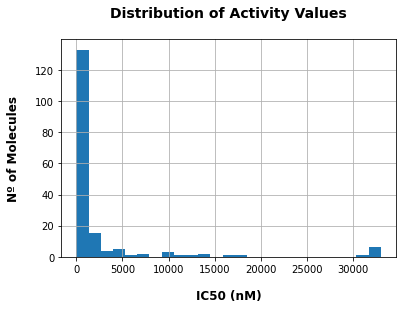

In [ ]:
fig_1, ax = plt.subplots()
ax = data['IC50 (nM)'].hist(bins=25)
ax.set_xlabel('IC50 (nM)', fontsize=12, fontweight='bold', labelpad=15)
ax.set_ylabel('Nº of Molecules', fontsize=12, fontweight='bold', labelpad=15)
ax.set_title('Distribution of Activity Values', fontsize=14, fontweight='bold', pad=22);

We can improve upon this by computing the natural logarithm of the IC50 instead, and using that as our response feature instead. We will also change the units of the IC50 from nM to M, so we can then directly compare these values with the Gibbs free energy.

In [ ]:
# Define response variable for classification.
data['IC50_clf'] = (data['IC50 (nM)'].to_numpy() < 100).astype('int')

In [ ]:
# Define response variable for regression.
data['IC50 (nM)'] = np.log(data['IC50 (nM)']*1e-9)
data = data.rename(columns={'IC50 (nM)': 'ln(IC50 (M))'})

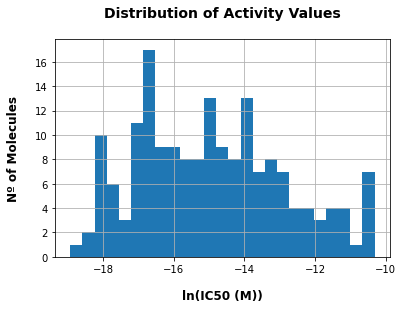

In [ ]:
fig_2, ax = plt.subplots()
ax = data['ln(IC50 (M))'].hist(bins=25)
ax.set_xlabel('ln(IC50 (M))', fontsize=12, fontweight='bold', labelpad=15)
ax.set_ylabel('Nº of Molecules', fontsize=12, fontweight='bold', labelpad=15)
ax.set_title('Distribution of Activity Values', fontsize=14, fontweight='bold', pad=22);

Standardize data for principal components analysis.

In [ ]:
standard_df = prep.StandardizeDF(data, ['Unnamed: 0', 'Title', 'SMILES', 'ln(IC50 (M))', 'IC50_clf', 'ClusterIdx'])

In [ ]:
features = fa.FeatureList(standard_df.drop(columns=['Unnamed: 0', 'Title', 'ln(IC50 (M))', 'IC50_clf', 'SMILES', 'ClusterIdx']),
                          data['ln(IC50 (M))'])

In [ ]:
# Same features object but with IC50_clf as the response feature.
features_clf = fa.FeatureList(standard_df.drop(columns=['Unnamed: 0', 'Title', 'ln(IC50 (M))', 'IC50_clf', 'SMILES', 'ClusterIdx']),
                          data['IC50_clf'])

# PCA All Features

Perform PCA on all features and obtain enough principal components to retain 95% of the variance in the original dataset.

In [ ]:
PCA_all = PCA(n_components=0.95)

In [ ]:
X_pca = PCA_all.fit_transform(features.feature_df.to_numpy())

In [ ]:
cols = [f'PCA_all_{i+1}' for i in range(PCA_all.n_components_)]
PCA_all_df = pd.DataFrame(X_pca, columns=cols)
PCA_all_df

PCA_all_1  PCA_all_2  PCA_all_3  ...  PCA_all_15  PCA_all_16  PCA_all_17
0     2.036987   3.392095   3.602475  ...   -0.842254    0.487617   -0.155057
1    -3.874307   1.176991  -0.266598  ...    1.076597    0.211286   -0.443901
2    -3.874307   1.176991  -0.266598  ...    1.076597    0.211286   -0.443901
3    -4.511491   0.084611   0.075211  ...    0.147850   -0.017312    0.311985
4    -4.814047   0.487045  -0.267194  ...    0.152806   -0.309335   -0.504311
..         ...        ...        ...  ...         ...         ...         ...
171   0.830817  -3.368027   4.115276  ...    0.050063   -0.798284    1.985504
172   0.025489  -4.277504   4.084247  ...    0.269060    0.240366    2.126358
173   1.638853  -2.513696   7.294980  ...    0.697202    0.298308    0.932225
174   0.475817  -3.646251   6.507637  ...    0.085911   -0.645260   -0.343957
175  -1.559441  -1.715628  -0.951932  ...   -0.397533    1.367511   -0.336306

[176 rows x 17 columns]

We can look at the amount of variance of the original dataset each of these features represents.

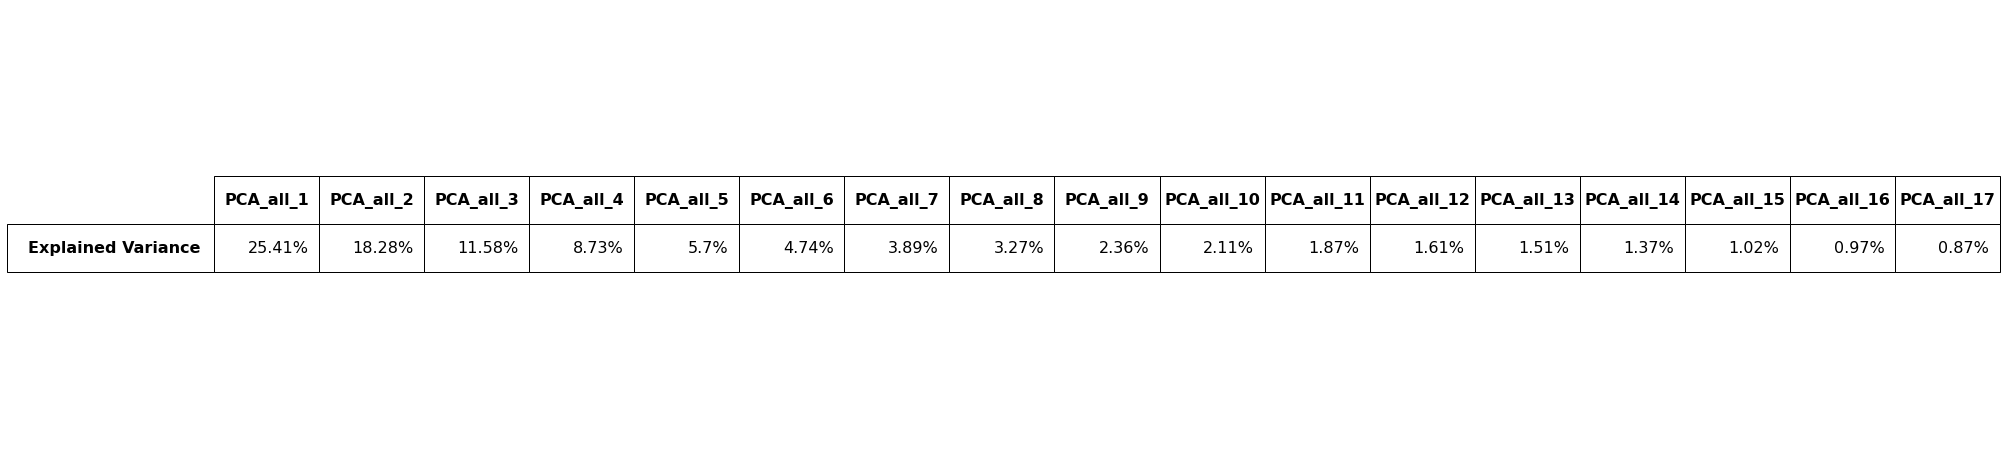

In [ ]:
variances = np.array([f'{round(var*100, 2)}%' for var in PCA_all.explained_variance_ratio_]).reshape(1, -1)
PCA_all_var_df = pd.DataFrame(variances, columns=cols, index=['Explained Variance'])
fig_3, ax = Utils.DFAsTable(PCA_all_var_df, dtype='str')
fig_3.set_size_inches(32, 8)

Zenbat mantedu hemendik?? Momentuz 8 utzi ditut, zerbait jartzeagatik.

In [ ]:
PCA_all_df = PCA_all_df.iloc[:, :8]

# Feature Correlations

The first goal of our feaure analysis is, to the best extent possible, eliminate correlations within the feature correlation matrix, so that all our algorithms are not being given redundant information.

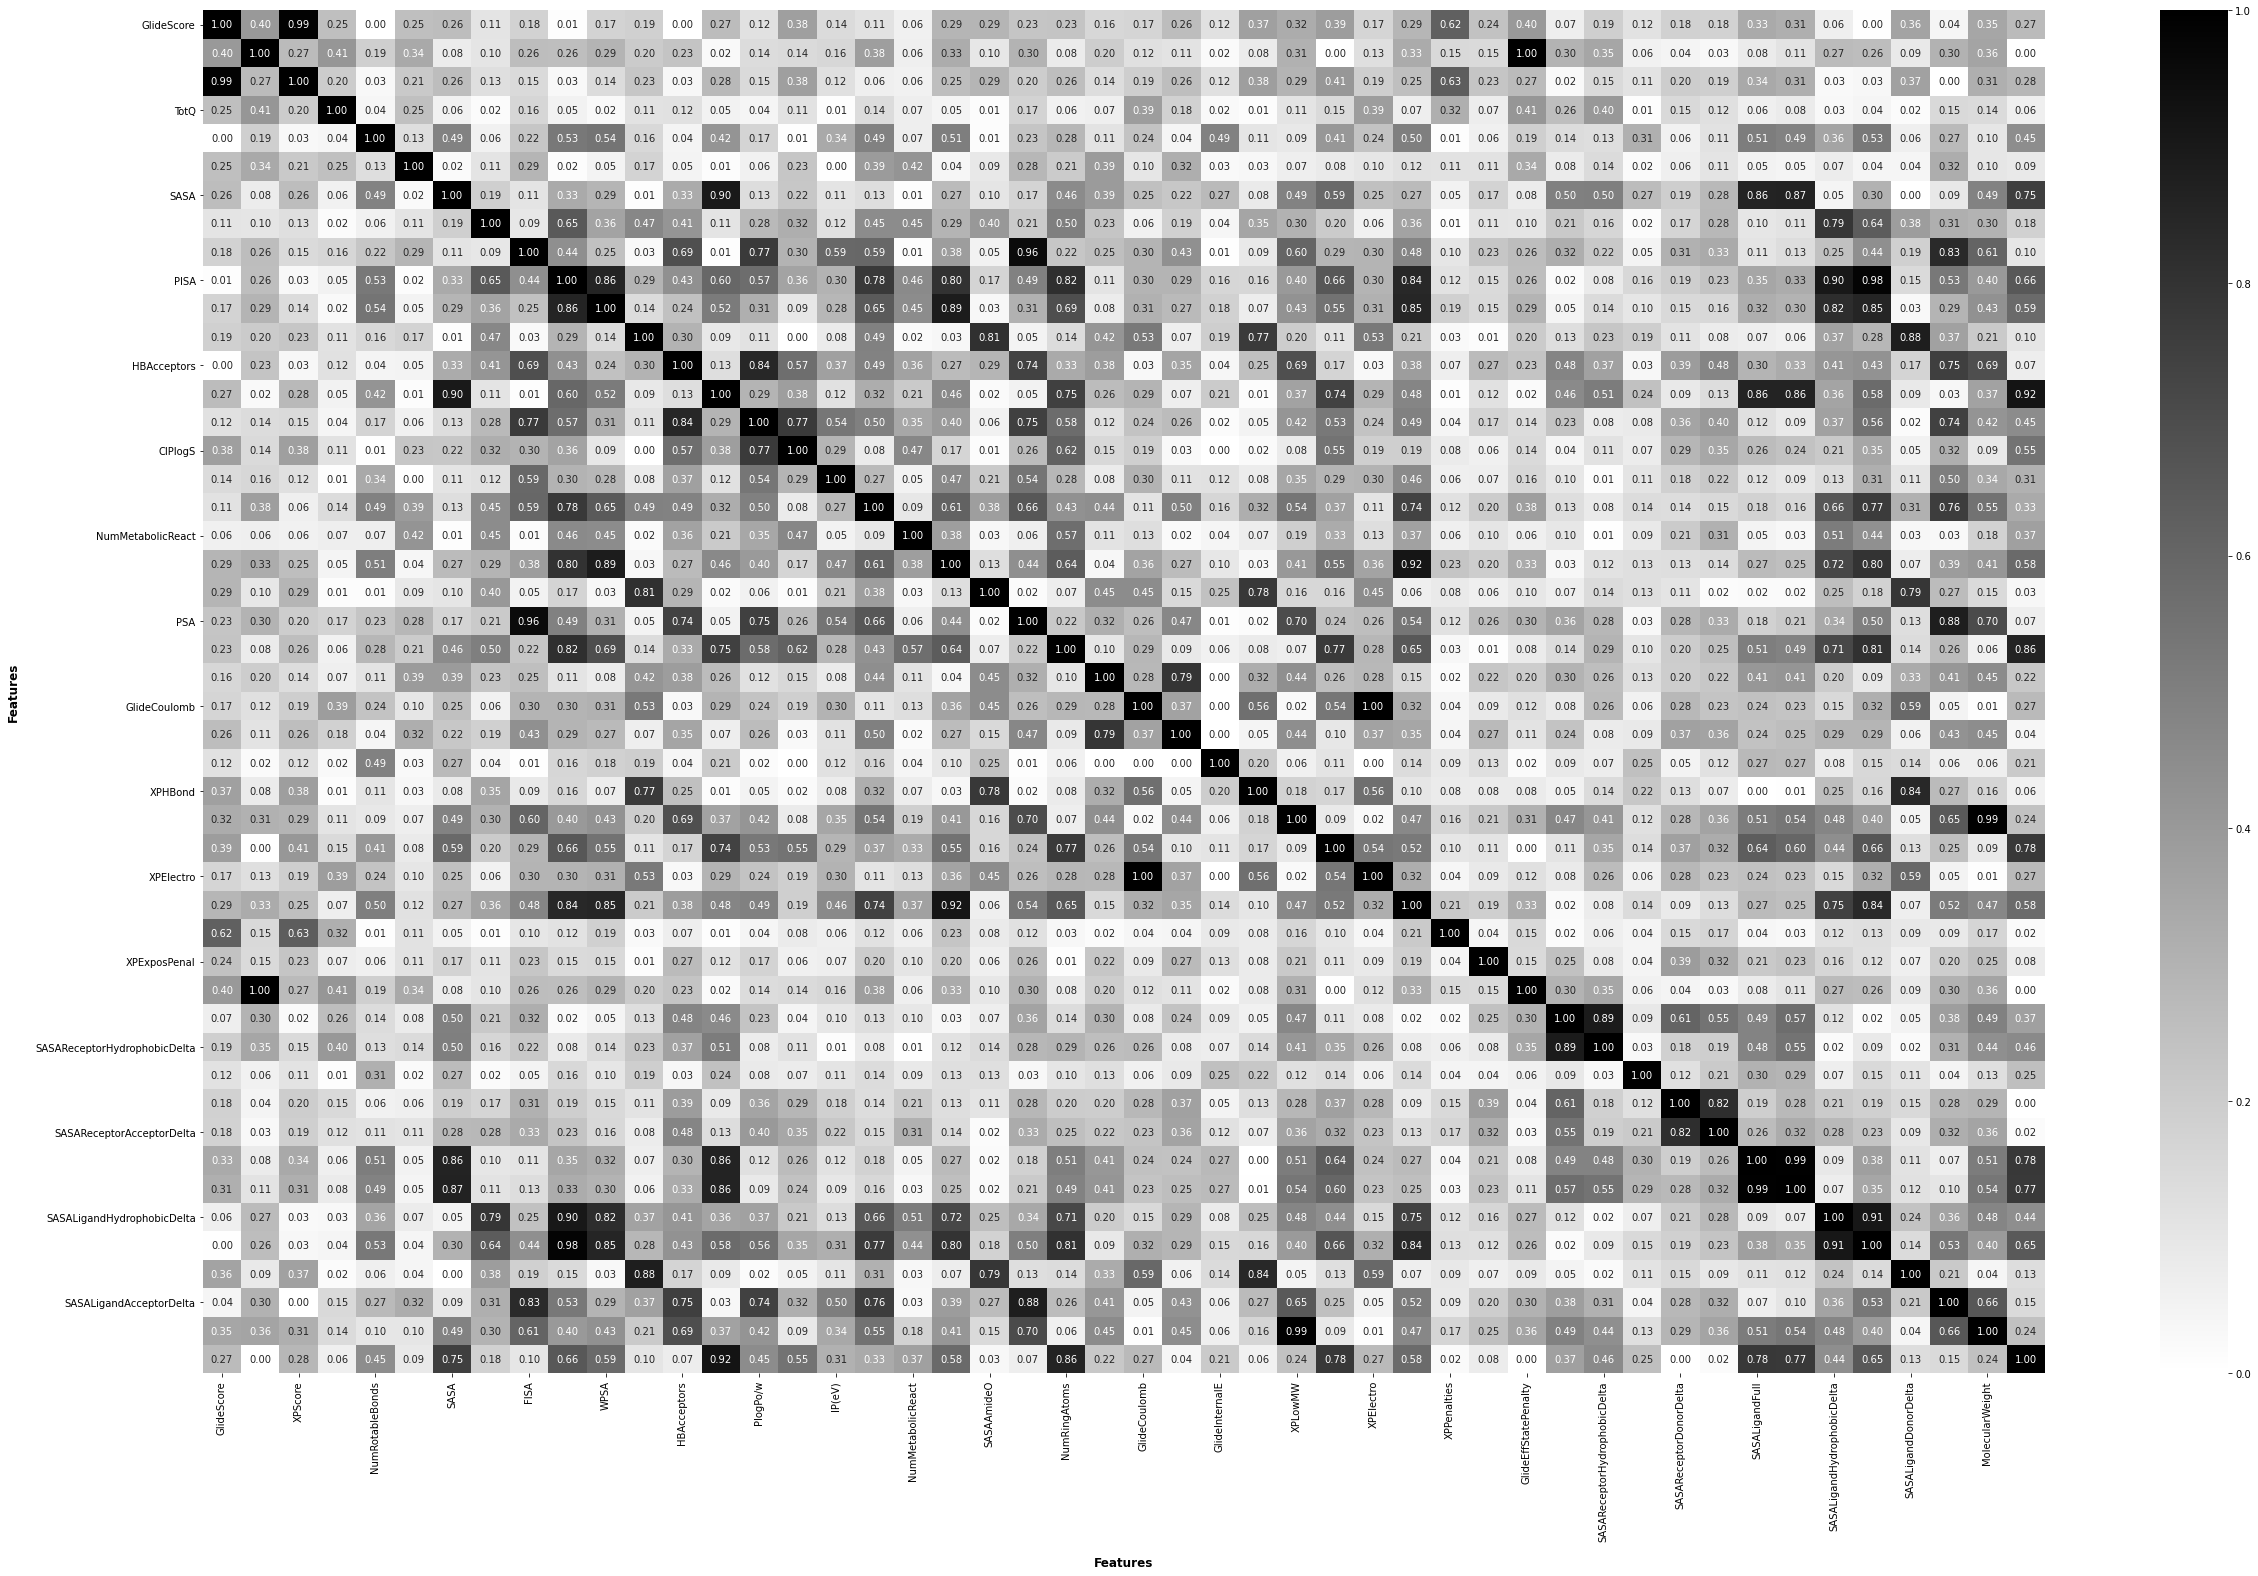

In [ ]:
fig_4, ax = features.draw_correlation()
fig_4.set_size_inches(35, 22)
fig_4.tight_layout()

# Feature Clustering

We will cluster this correlation matrix so that we can first create principal components within the feature clusters and then eliminate correlated features.

## Hierarchical clustering

The algorithm of choice for the clustering of features is hierarchical clustering. However, we must first inspect the most optimal linkage method for the algorithm. For now, we will set 0.75 as our cutoff correlation for defining feature clusters.


### Hierarchical Clustering: Ward Linkage

The objective of the Ward linkage criterion is to minimize within cluster variance. Therefore, in ward linkage hierarchical clustering, the distance between clusters is determined based on the amount of variance increase that the merging of adjacent clusters A and B would lead to.

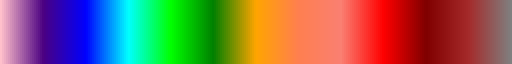

In [ ]:
custom_colormap = LinearSegmentedColormap.from_list('custom_cm', ['pink', 'indigo', 'blue', 'cyan', 'lime','green',
                                                                  'orange', 'coral', 'salmon', 'red', 'maroon',
                                                                  'brown', 'grey'])
custom_colormap

In [ ]:
features.cluster_features(threshold=0.68, colormap=custom_colormap)

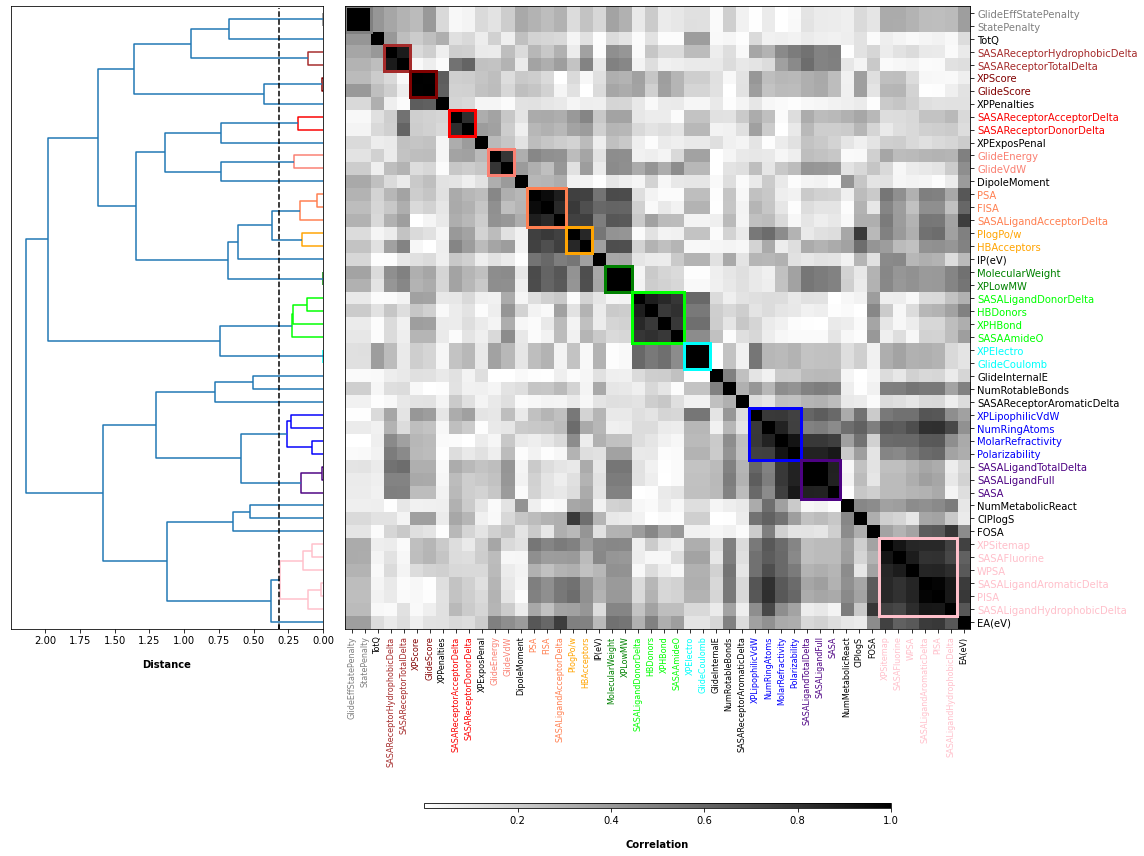

In [ ]:
fig_5, ax = features.draw_clusters()
fig_5.set_size_inches(16, 12)
fig_5.tight_layout()

In [ ]:
summary_1, _ = features.analyize_clusters(correlation_threshold=0.8, color_clusters=True)

### Hierarchical Clustering: Single Linkage

In single linkage hierarchical clustering, the distance between clusters is determined by the minimum distance between points of adjacent clusters A and B.

$$\min \{ d(a, b): a \in A, b \in B \}$$

In [ ]:
features.cluster_features(threshold=0.75, linkage='single', colormap=custom_colormap)

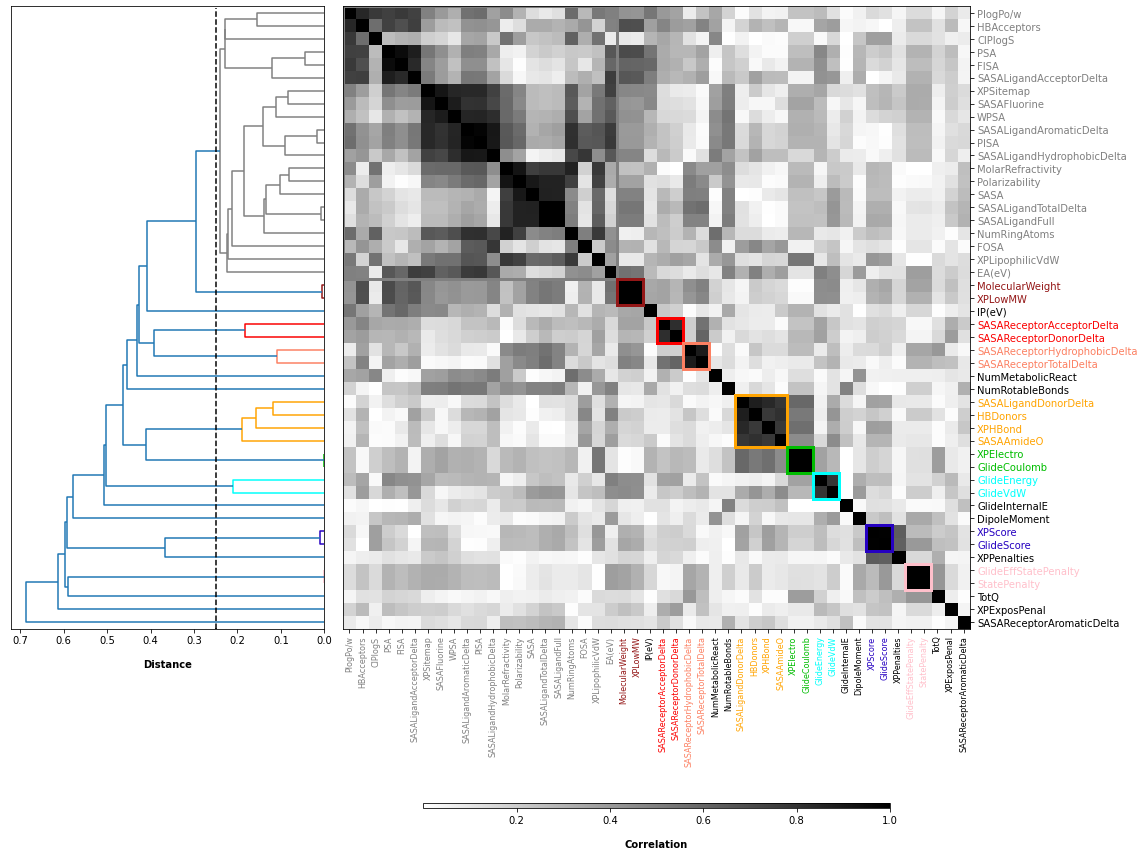

In [ ]:
fig_6, ax = features.draw_clusters()
fig_6.set_size_inches(16, 12)
fig_6.tight_layout()

In [ ]:
summary_2, _ = features.analyize_clusters(correlation_threshold=0.8, color_clusters=True)

### Hierarchical Clustering: Complete Linkage



In complete linkage hierarchical clustering, the distance between clusters is determined by the maximum distance between points of adjacent clusters A and B.

$$\max \{ d(a, b): a \in A, b \in B \}$$

In [ ]:
features.cluster_features(threshold=0.68, linkage='complete', colormap=custom_colormap)

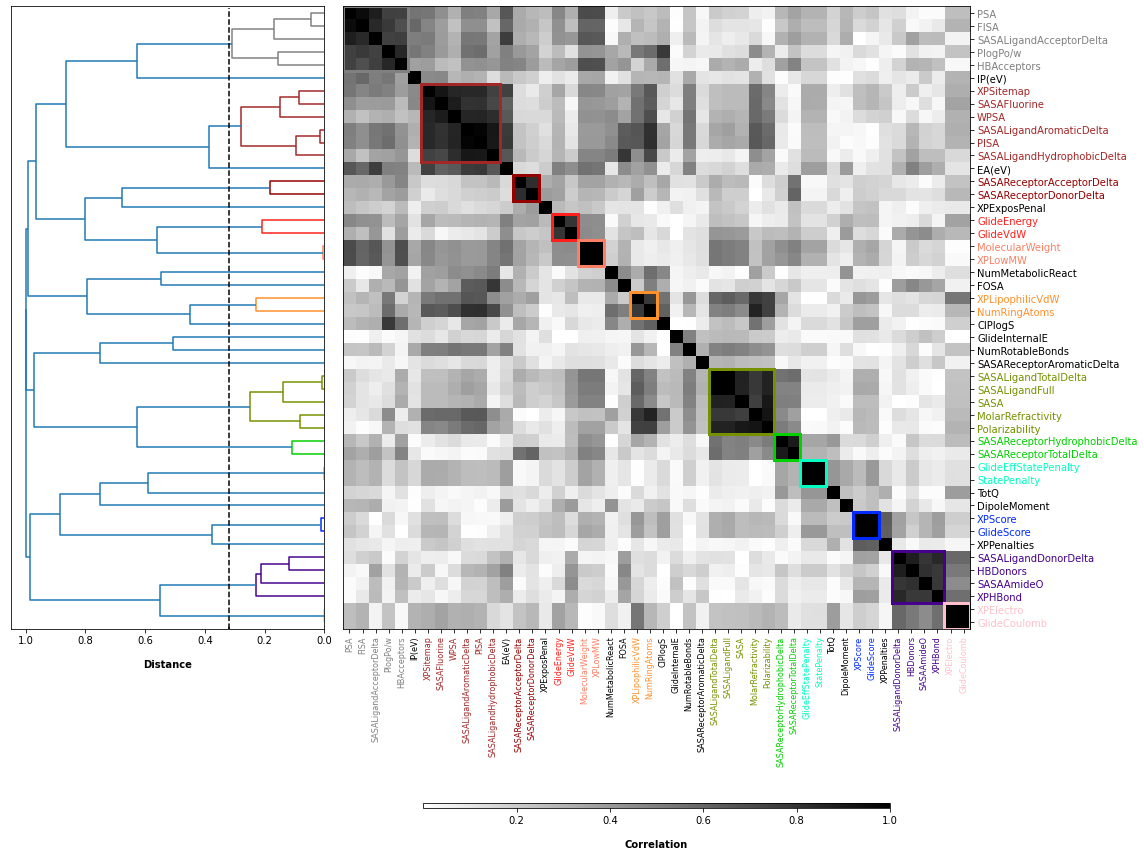

In [ ]:
fig_7, ax = features.draw_clusters()
fig_7.set_size_inches(16, 12)
fig_7.tight_layout()

In [ ]:
summary_3, _ = features.analyize_clusters(correlation_threshold=0.8, color_clusters=True)

### Hierarchical Clustering: Average Linkage

In average linkage hierarchical clustering, the distance between clusters is determined by the average distance between all points of adjacent clusters A and B.

$$\frac {1}{|A|.|B|}\sum_{a \in A}\sum_{b \in B}d(a, b)$$

In [ ]:
features.cluster_features(threshold=0.72, linkage='average', colormap=custom_colormap)

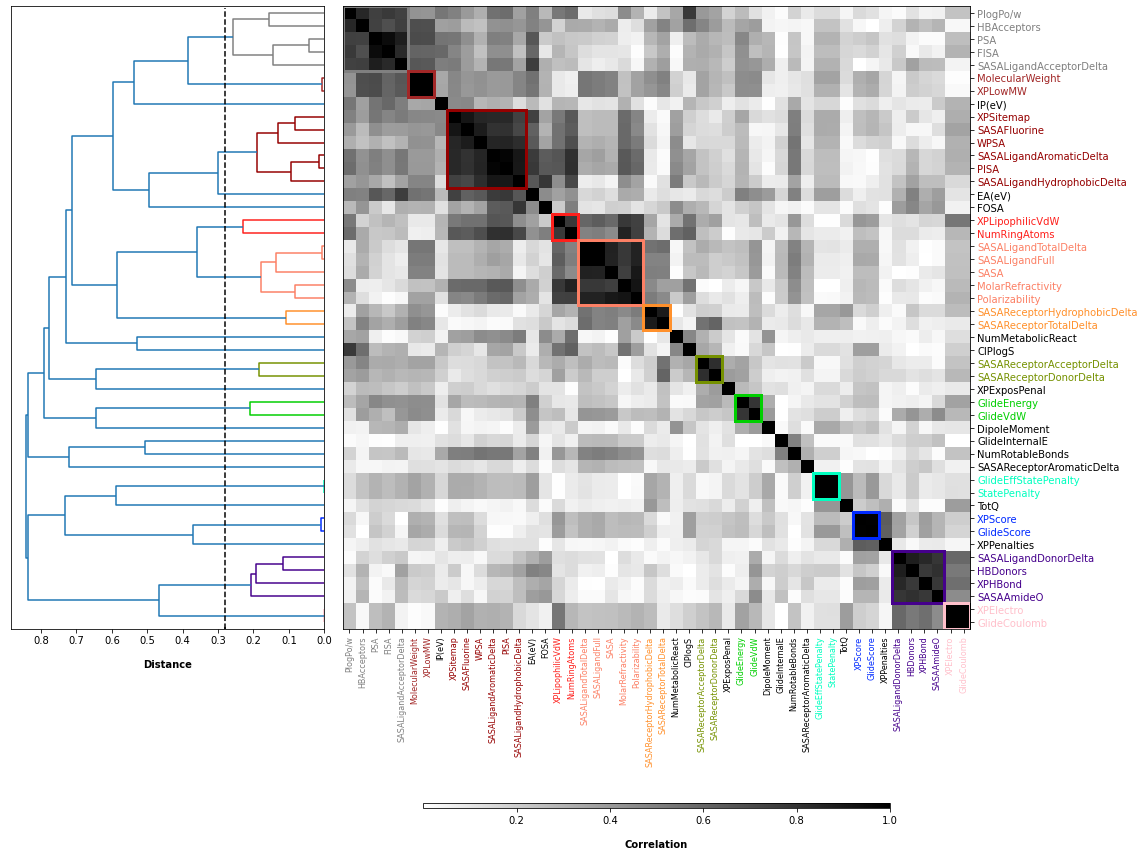

In [ ]:
fig_8, ax = features.draw_clusters()
fig_8.set_size_inches(16, 12)
fig_8.tight_layout()

In [ ]:
summary_4, _ = features.analyize_clusters(correlation_threshold=0.8, color_clusters=True)

### Hierarchical Clustering: Centroid Linkage

In centroid linkage hierarchical clustering, the distance between clusters is determined by the distance between centroids of adjacent clusters A and B.
$$||c_{A} - c_{B}||$$

Where $c_{A}$ and $c_{B}$ are the centroids of clusters A and B, respectively.

In [ ]:
features.cluster_features(threshold=0.75, linkage='centroid', colormap=custom_colormap)

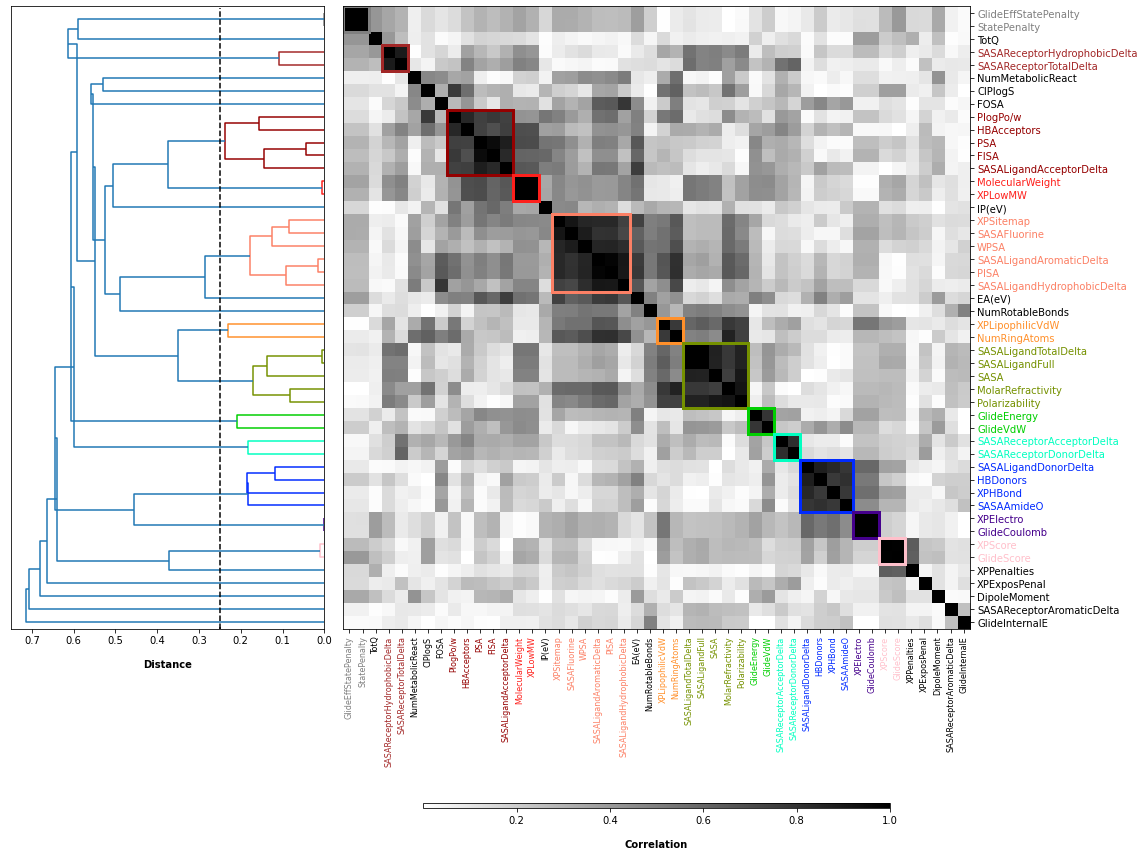

In [ ]:
fig_9, ax = features.draw_clusters()
fig_9.set_size_inches(16, 12)
fig_9.tight_layout()

In [ ]:
summary_5, _ = features.analyize_clusters(correlation_threshold=0.8, color_clusters=True)

In [ ]:
all_summary = pd.concat([summary_1, summary_2, summary_3, summary_4, summary_5])
all_summary.index = ['Ward Linkage', 'Single Linkage', 'Complete Linkage', 'Average Linkage', 'Centroid Linkage']
all_summary

Number of Clusters  ...  Number of Unclustered Correlations Above Threshold
Ward Linkage                      13  ...                                                  5 
Single Linkage                     9  ...                                                  0 
Complete Linkage                  12  ...                                                  3 
Average Linkage                   12  ...                                                  3 
Centroid Linkage                  12  ...                                                  3 

[5 rows x 5 columns]

Hauetatik bat aukeratu behar da eta threshold egokia aukeratu. Ikusi daiteke single linkage metodo txarrena dela (klusterren barruko korrelazioa oso txikia, kluster erraldoi bakarra sortzen duelako). Complete, average eta centroid linkage metodoek emaitza berak lortzen dituzte, naiz eta bertara bide desberdinetatik heldu. Emaitza hauek Ward linkage baino apur bat hobeak dirudite, klusterretik kanpo korrelazio altu gutxiago geratzen baitira, baina oso antzekoa da. Beraz adibidez, complete linkage metodoa aukera dezakegu??

In [ ]:
# Final clustering
features.cluster_features(threshold=0.68, linkage='complete', colormap=custom_colormap)

# Clusterwise PCA

We can now perform Principal Components Analysis on the features of each cluster. The goal is to obtain single features that represent a large percentage of the variance within each cluster. The hope is that since a large percentage of the variance is retained, most of the information of the features within the cluster is represented in these principal components.

Korrelazio desberdinak frogatuko ditugu edo klustering egiteko erabilitako korrelazio thresholda jarriko dugu besterik gabe? Bat baino gehiago frogatuz gero, bakarra erabiliko dugu edo PCA desberdinetatik lortutako aldagaiak nahastuko ditugu?

Momentuz, klusteringa egiteko thresholda erabiliko dut. Gutxienez 3 feature dauzkaten klusterrak erabiliko ditut, eta kluster bakoitzetik lehen konponentea soilik aukeratuko dut.

### Clustering with 0.68 Correlation Threshold.

In [ ]:
features.cluster_features(threshold=0.68)

In [ ]:
PCA_cluster68_df, PCA_cluster68_var_df = features.cluster_pca(min_cluster_len=2, components=1)

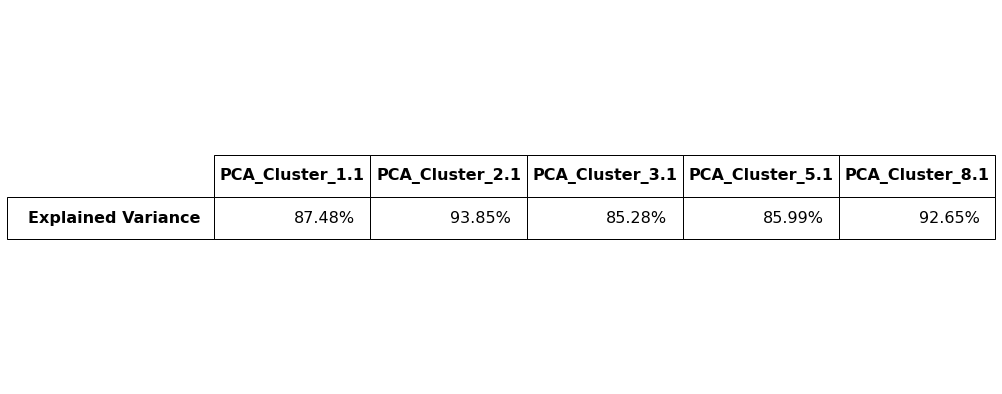

In [ ]:
PCA_cluster68_var_df.index = ['Explained Variance']
fig_10, ax = Utils.DFAsTable(PCA_cluster68_var_df, dtype='str')
fig_10.set_size_inches(14, 7)

Add PCA features and cluster again.

In [ ]:
features.add_features(pd.concat([PCA_all_df, PCA_cluster68_df], axis=1))
features_clf.add_features(pd.concat([PCA_all_df, PCA_cluster68_df], axis=1))

In [ ]:
features.cluster_features(threshold=0.68, colormap=custom_colormap)

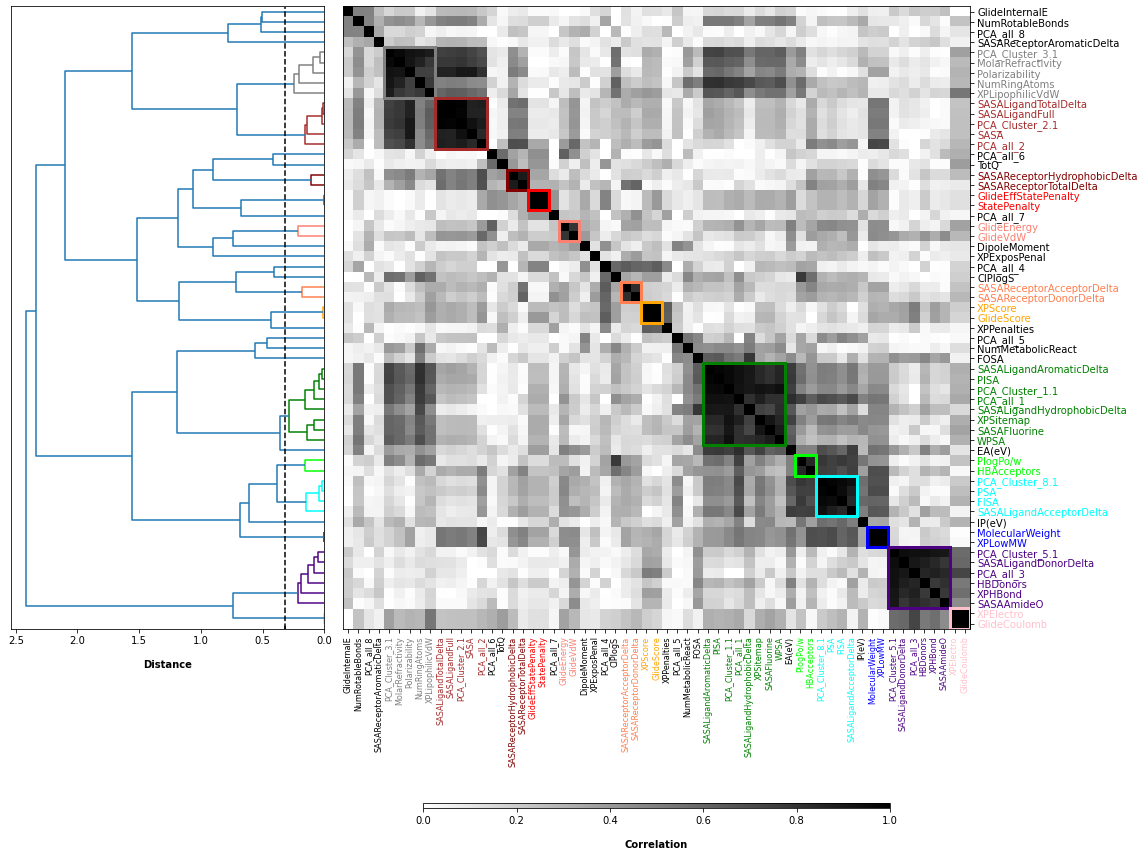

In [ ]:
fig_11, ax = features.draw_clusters()
fig_11.set_size_inches(16, 12)
fig_11.tight_layout()

In [ ]:
summary_1, _ = features.analyize_clusters(correlation_threshold=0.8)

In [ ]:
features.cluster_features(threshold=0.68, linkage='single', colormap=custom_colormap)

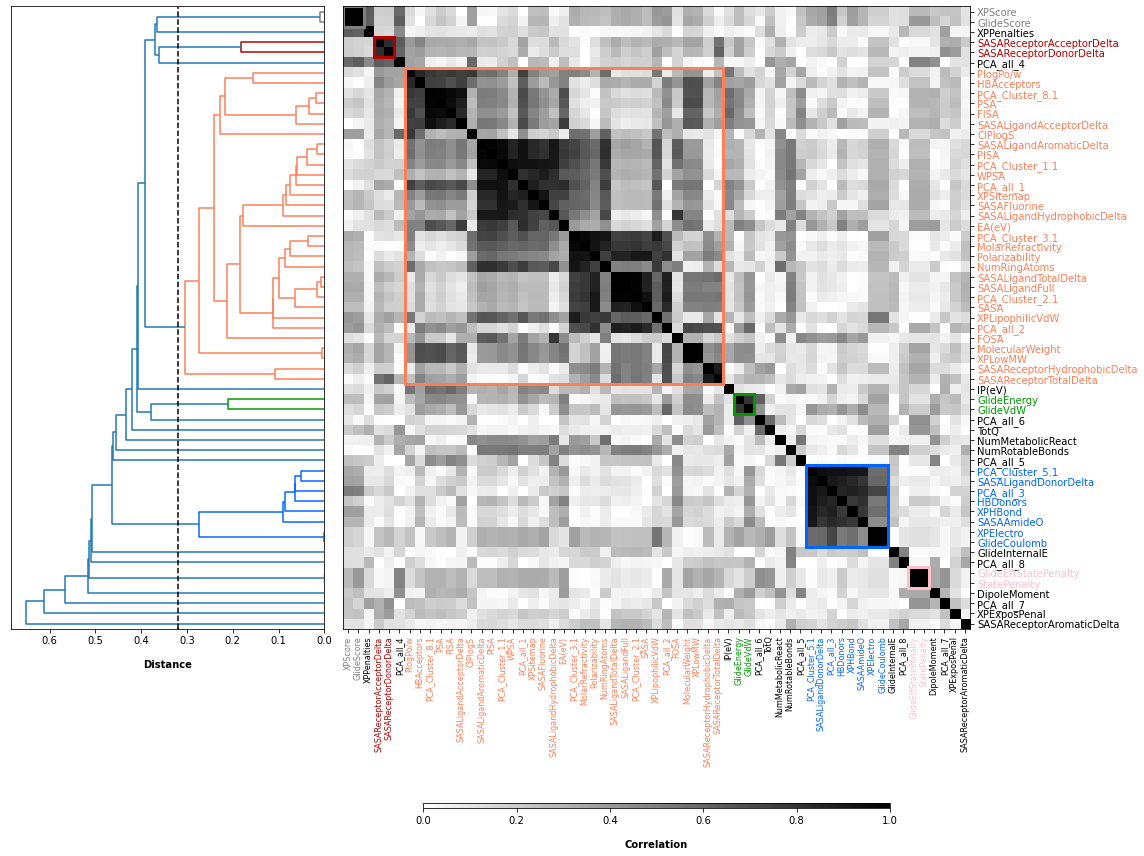

In [ ]:
fig_12, ax = features.draw_clusters()
fig_12.set_size_inches(16, 12)
fig_12.tight_layout()

In [ ]:
summary_2, _ = features.analyize_clusters(correlation_threshold=0.8)

In [ ]:
features.cluster_features(threshold=0.68, linkage='complete', colormap=custom_colormap)

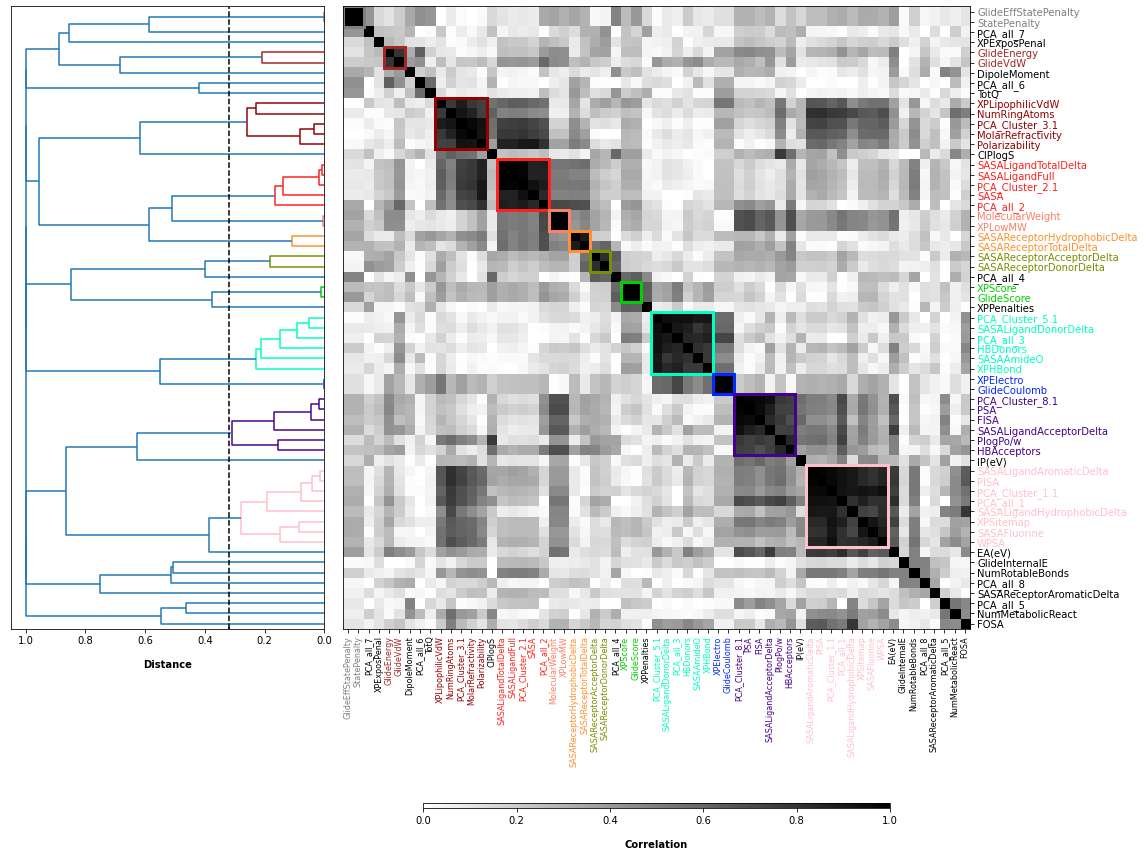

In [ ]:
fig_13, ax = features.draw_clusters()
fig_13.set_size_inches(16, 12)
fig_13.tight_layout()

In [ ]:
summary_3, _ = features.analyize_clusters(correlation_threshold=0.8)

In [ ]:
features.cluster_features(threshold=0.68, linkage='average', colormap=custom_colormap)

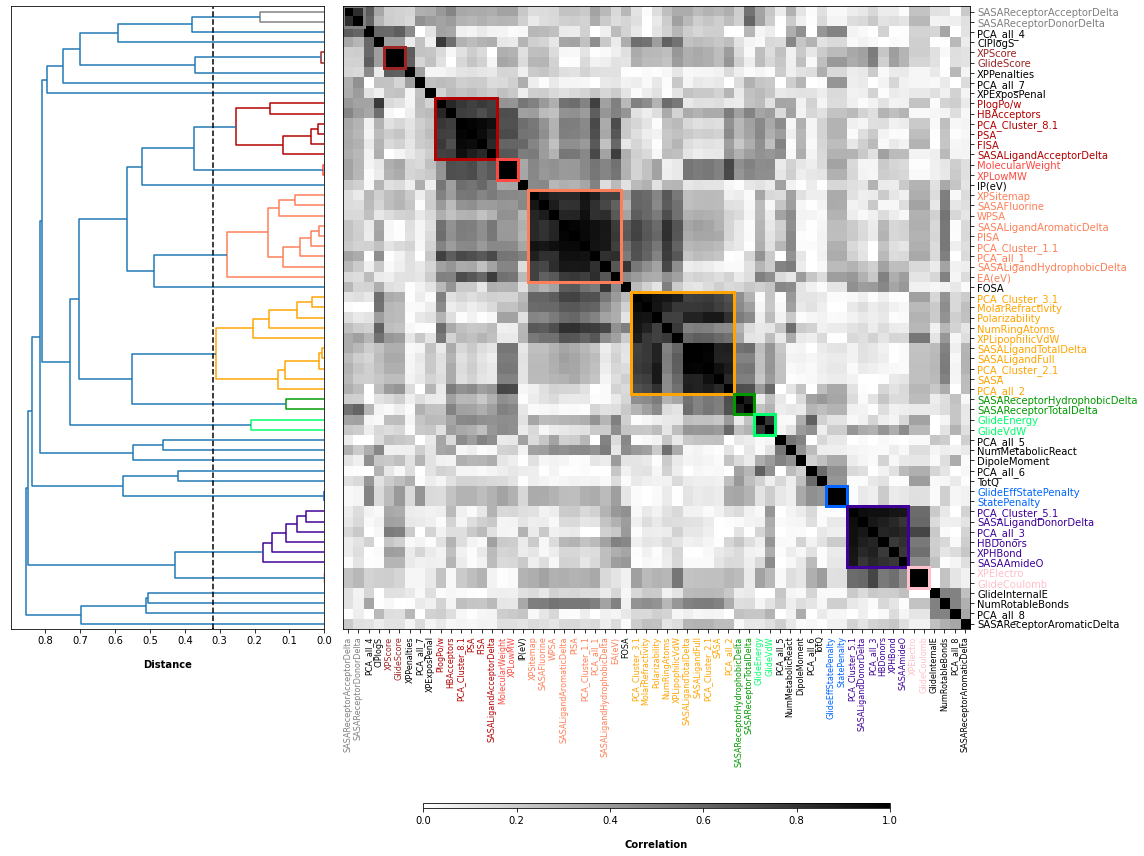

In [ ]:
fig_14, ax = features.draw_clusters()
fig_14.set_size_inches(16, 12)
fig_14.tight_layout()

In [ ]:
summary_4, _ = features.analyize_clusters(correlation_threshold=0.8)

In [ ]:
features.cluster_features(threshold=0.68, linkage='centroid', colormap=custom_colormap)

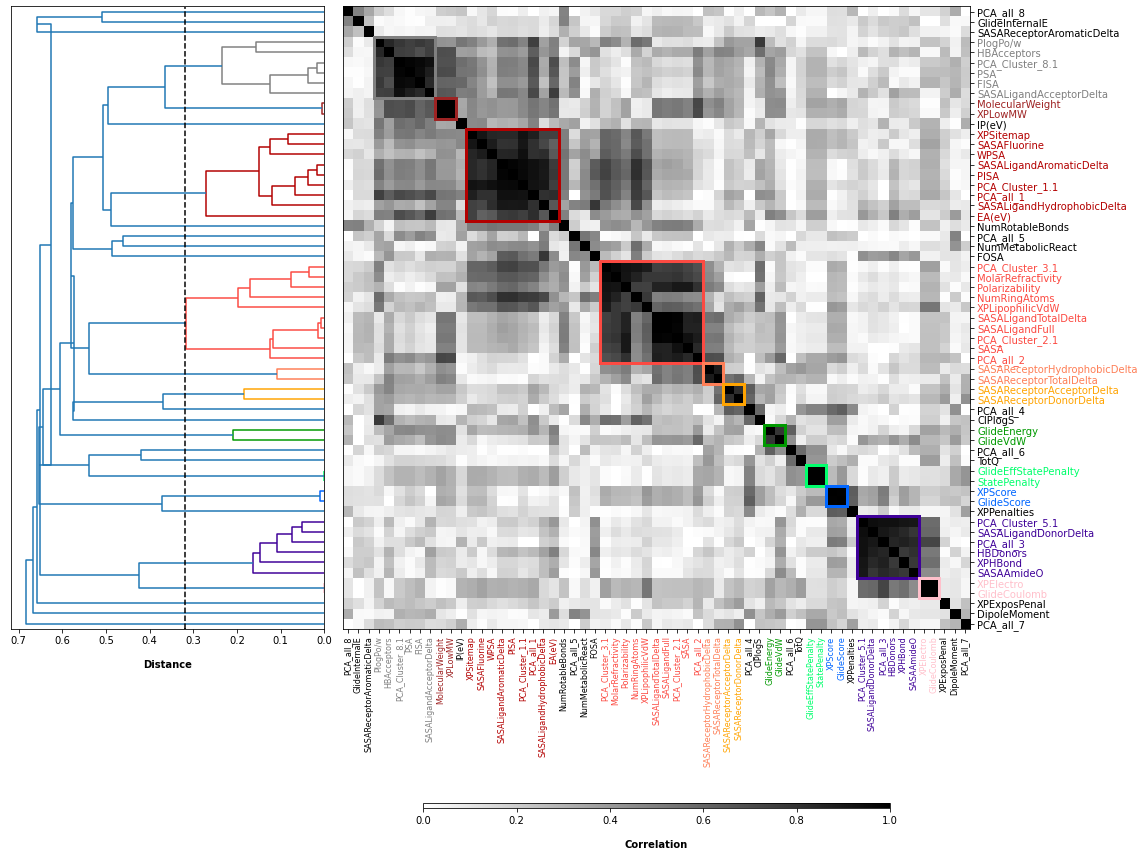

In [ ]:
fig_15, ax = features.draw_clusters()
fig_15.set_size_inches(16, 12)
fig_15.tight_layout()

In [ ]:
summary_5, _ = features.analyize_clusters(correlation_threshold=0.8)

In [ ]:
all_summary = pd.concat([summary_1, summary_2, summary_3, summary_4, summary_5])
all_summary.index = ['Ward Linkage', 'Single Linkage', 'Complete Linkage', 'Average Linkage', 'Centroid Linkage']
all_summary

Number of Clusters  ...  Number of Unclustered Correlations Above Threshold
Ward Linkage                      13  ...                                                  8 
Single Linkage                     6  ...                                                  0 
Complete Linkage                  12  ...                                                  8 
Average Linkage                   11  ...                                                  2 
Centroid Linkage                  11  ...                                                  2 

[5 rows x 5 columns]

Hemen lehen bezalako zerbait gertatzen da, baina oraingoan average eta centroid linkage metodoekin lortzen da emaitza berdina, eta bi kasuetan dira korrelazio altuko puntu kopurua minimoak, kluster handiagoak egiten dituztelako. Momentuz, centroid linkage metodoa erabiliko dut adibidez.

In [ ]:
features.cluster_features(threshold=0.68, linkage='centroid', colormap=custom_colormap)
features_clf.cluster_features(threshold=0.68, linkage='centroid', colormap=custom_colormap)

In [ ]:
summary, cluster_info = features.analyize_clusters(correlation_threshold=0.8, color_clusters=True)

In [ ]:
cluster_info

# Feature Selection

We will calculate the F-scores and mutual information of each feature as guides to help us choose the best features from each cluster.**bold text**

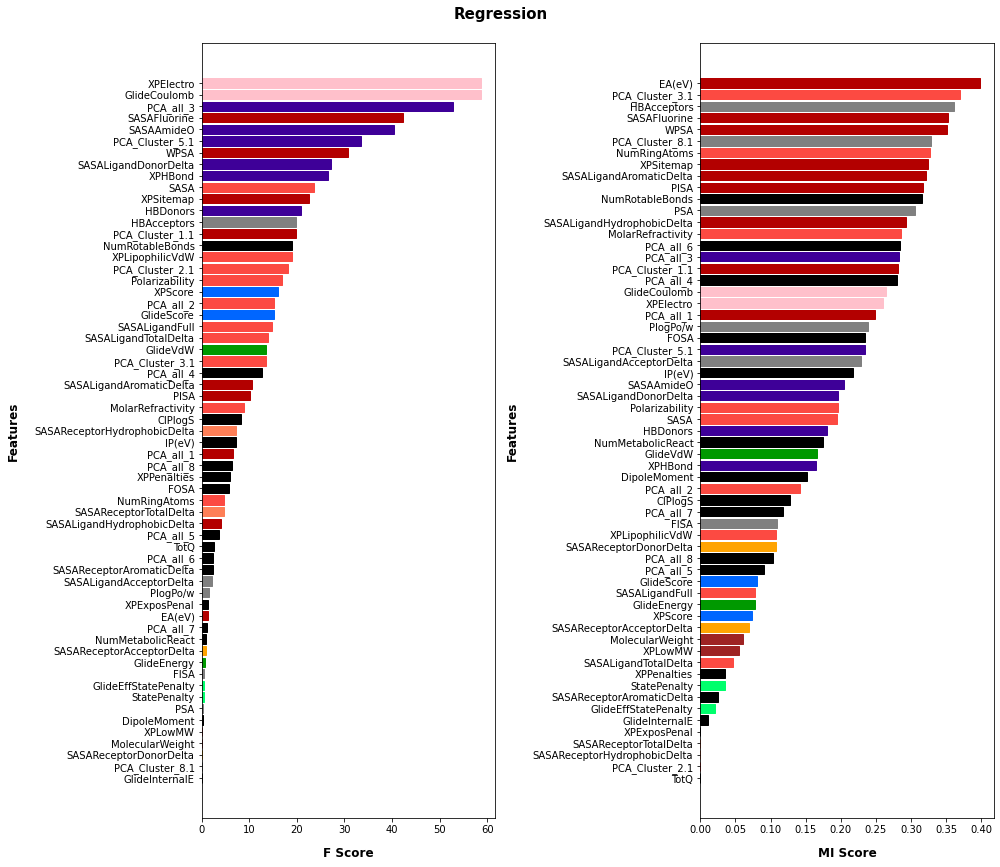

In [ ]:
fig_16, ax = features.eval_reg_features(color_clusters=True)
fig_16.set_size_inches(14, 12)
fig_16.suptitle('Regression', fontsize=15, fontweight='bold', horizontalalignment='center',
             y=1.0)
fig_16.tight_layout();

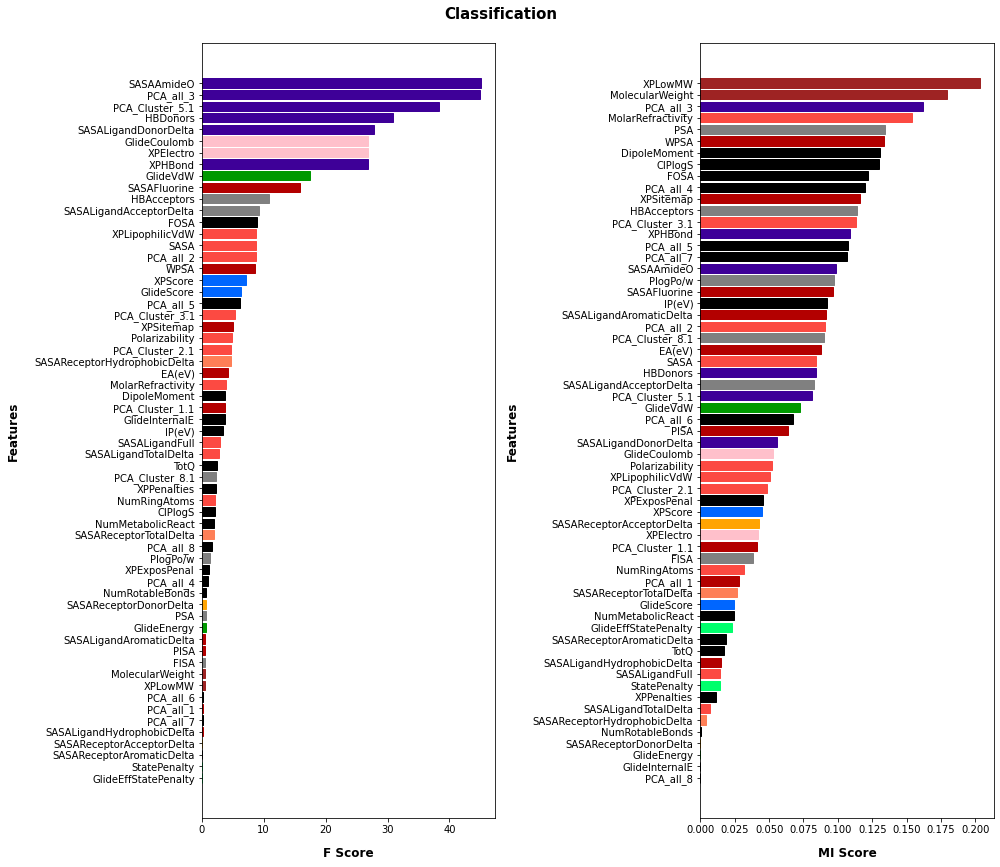

In [ ]:
fig_17, ax = features_clf.eval_clf_features(color_clusters=True)
fig_17.set_size_inches(14, 12)
fig_17.suptitle('Classification', fontsize=15, fontweight='bold', horizontalalignment='center',
             y=1.0)
fig_17.tight_layout();

First, we will eliminate of the of features in each cluster containing only two features. Some features have correlations close to 1, which means they are essentially the same features, so we can just remove one. For pairs of features with lower correlation, we will make the decision based on which one has the highest F and MI scores.

In [ ]:
features.remove_features(['StatePenalty', 'GlideCoulomb', 'MolecularWeight', 'GlideScore', 'SASAReceptorHydrophobicDelta',
                          'SASAReceptorDonorDelta', 'GlideEnergy'])

Second, we will eliminate unnecessary features within each cluster. We will plot the correlation matrix of each cluster, with the goal of keeping as much information within the cluster while removing as many correlations as possible. We will make these decisions based on the F and MI scores as well as the within-cluster correlations shown below.

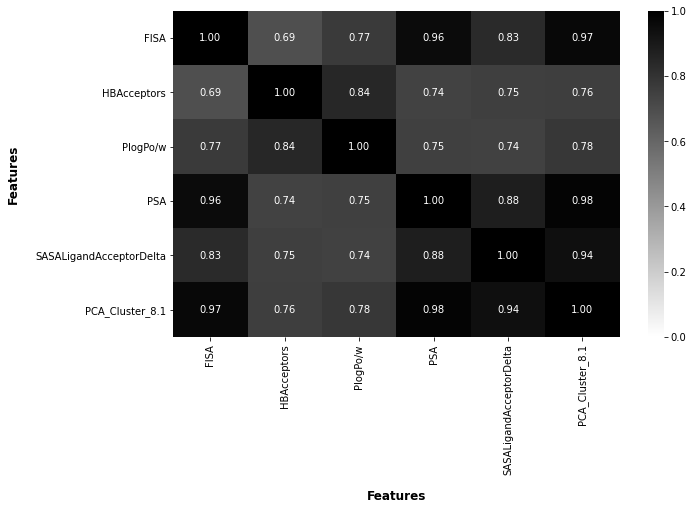

In [ ]:
fig_18, ax = features.draw_correlation(feature_subset=['FISA', 'HBAcceptors', 'PlogPo/w', 'PSA', 'SASALigandAcceptorDelta', 'PCA_Cluster_8.1'])
fig_18.set_size_inches(10, 6)

Hemendik utzi ditzakegu adibidez PCA_Cluster_8.1, PlogPo/w eta HBAcceptors? Hirurek score onak dauzkate eta haien arteko korrelazioak ez dira altuak.

In [ ]:
features.remove_features(['PSA', 'SASALigandAcceptorDelta', 'FISA'])

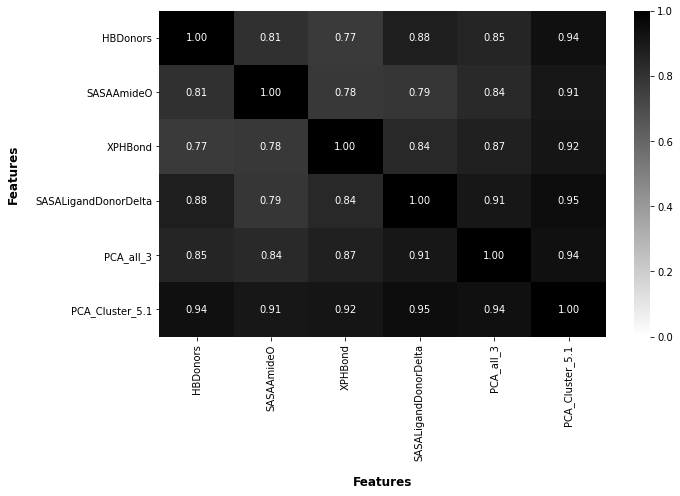

In [ ]:
fig_19, ax = features.draw_correlation(feature_subset=['HBDonors', 'SASAAmideO', 'XPHBond', 'SASALigandDonorDelta', 'PCA_all_3', 'PCA_Cluster_5.1'])
fig_19.set_size_inches(10, 6)

Hemen PCA_Cluster_5.1 erabili beharrean PCA_all_3 erabili daiteke beharbada, score oso onak baitdauzka, eta gero beste feature batzuk utzi ditzakegu, PCA_all_3-rekin korrelazioa hain altua ez daukatenak, adibidez XPHBond eta HBDonors. Hala ere, korrelazioa altua da, beraz behar bada PCA aldagaiarekin nahikoa da?

In [ ]:
features.remove_features(['SASAAmideO', 'SASALigandDonorDelta', 'PCA_Cluster_5.1'])

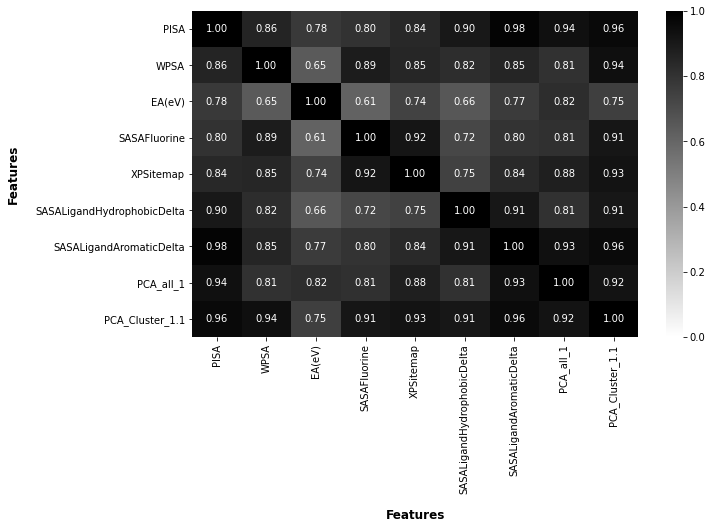

In [ ]:
fig_20, ax = features.draw_correlation(feature_subset=['PISA', 'WPSA', 'EA(eV)', 'SASAFluorine', 'XPSitemap', 'SASALigandHydrophobicDelta', 'SASALigandAromaticDelta', 'PCA_all_1', 'PCA_Cluster_1.1'])
fig_20.set_size_inches(10, 6)

Hemen aukera hoberenak ez dauzkat hain argi.

In [ ]:
features.remove_features(['PISA', 'XPSitemap', 'PCA_all_1', 'PCA_Cluster_1.1', 'SASALigandAromaticDelta'])

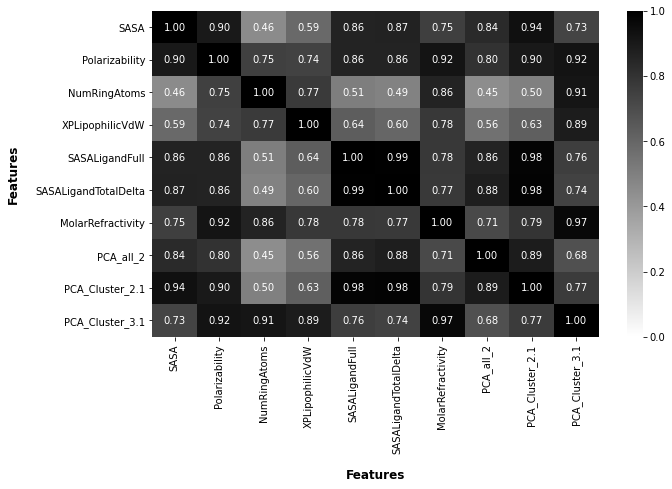

In [ ]:
fig_21, ax = features.draw_correlation(feature_subset=['SASA', 'Polarizability', 'NumRingAtoms', 'XPLipophilicVdW', 'SASALigandFull',
                                                    'SASALigandTotalDelta', 'MolarRefractivity', 'PCA_all_2', 'PCA_Cluster_2.1',
                                                    'PCA_Cluster_3.1'])
fig_21.set_size_inches(10, 6)

Hemen ere aukeraketa ez da sinplea, eztabaidatu beharko genuke.

In [ ]:
features.remove_features(['SASA', 'Polarizability', 'PCA_all_2', 'PCA_Cluster_3.1', 'SASALigandFull', 'SASALigandTotalDelta'])

Having removed most of the correlations within the feature set, we can now redraw the correlation matrix.

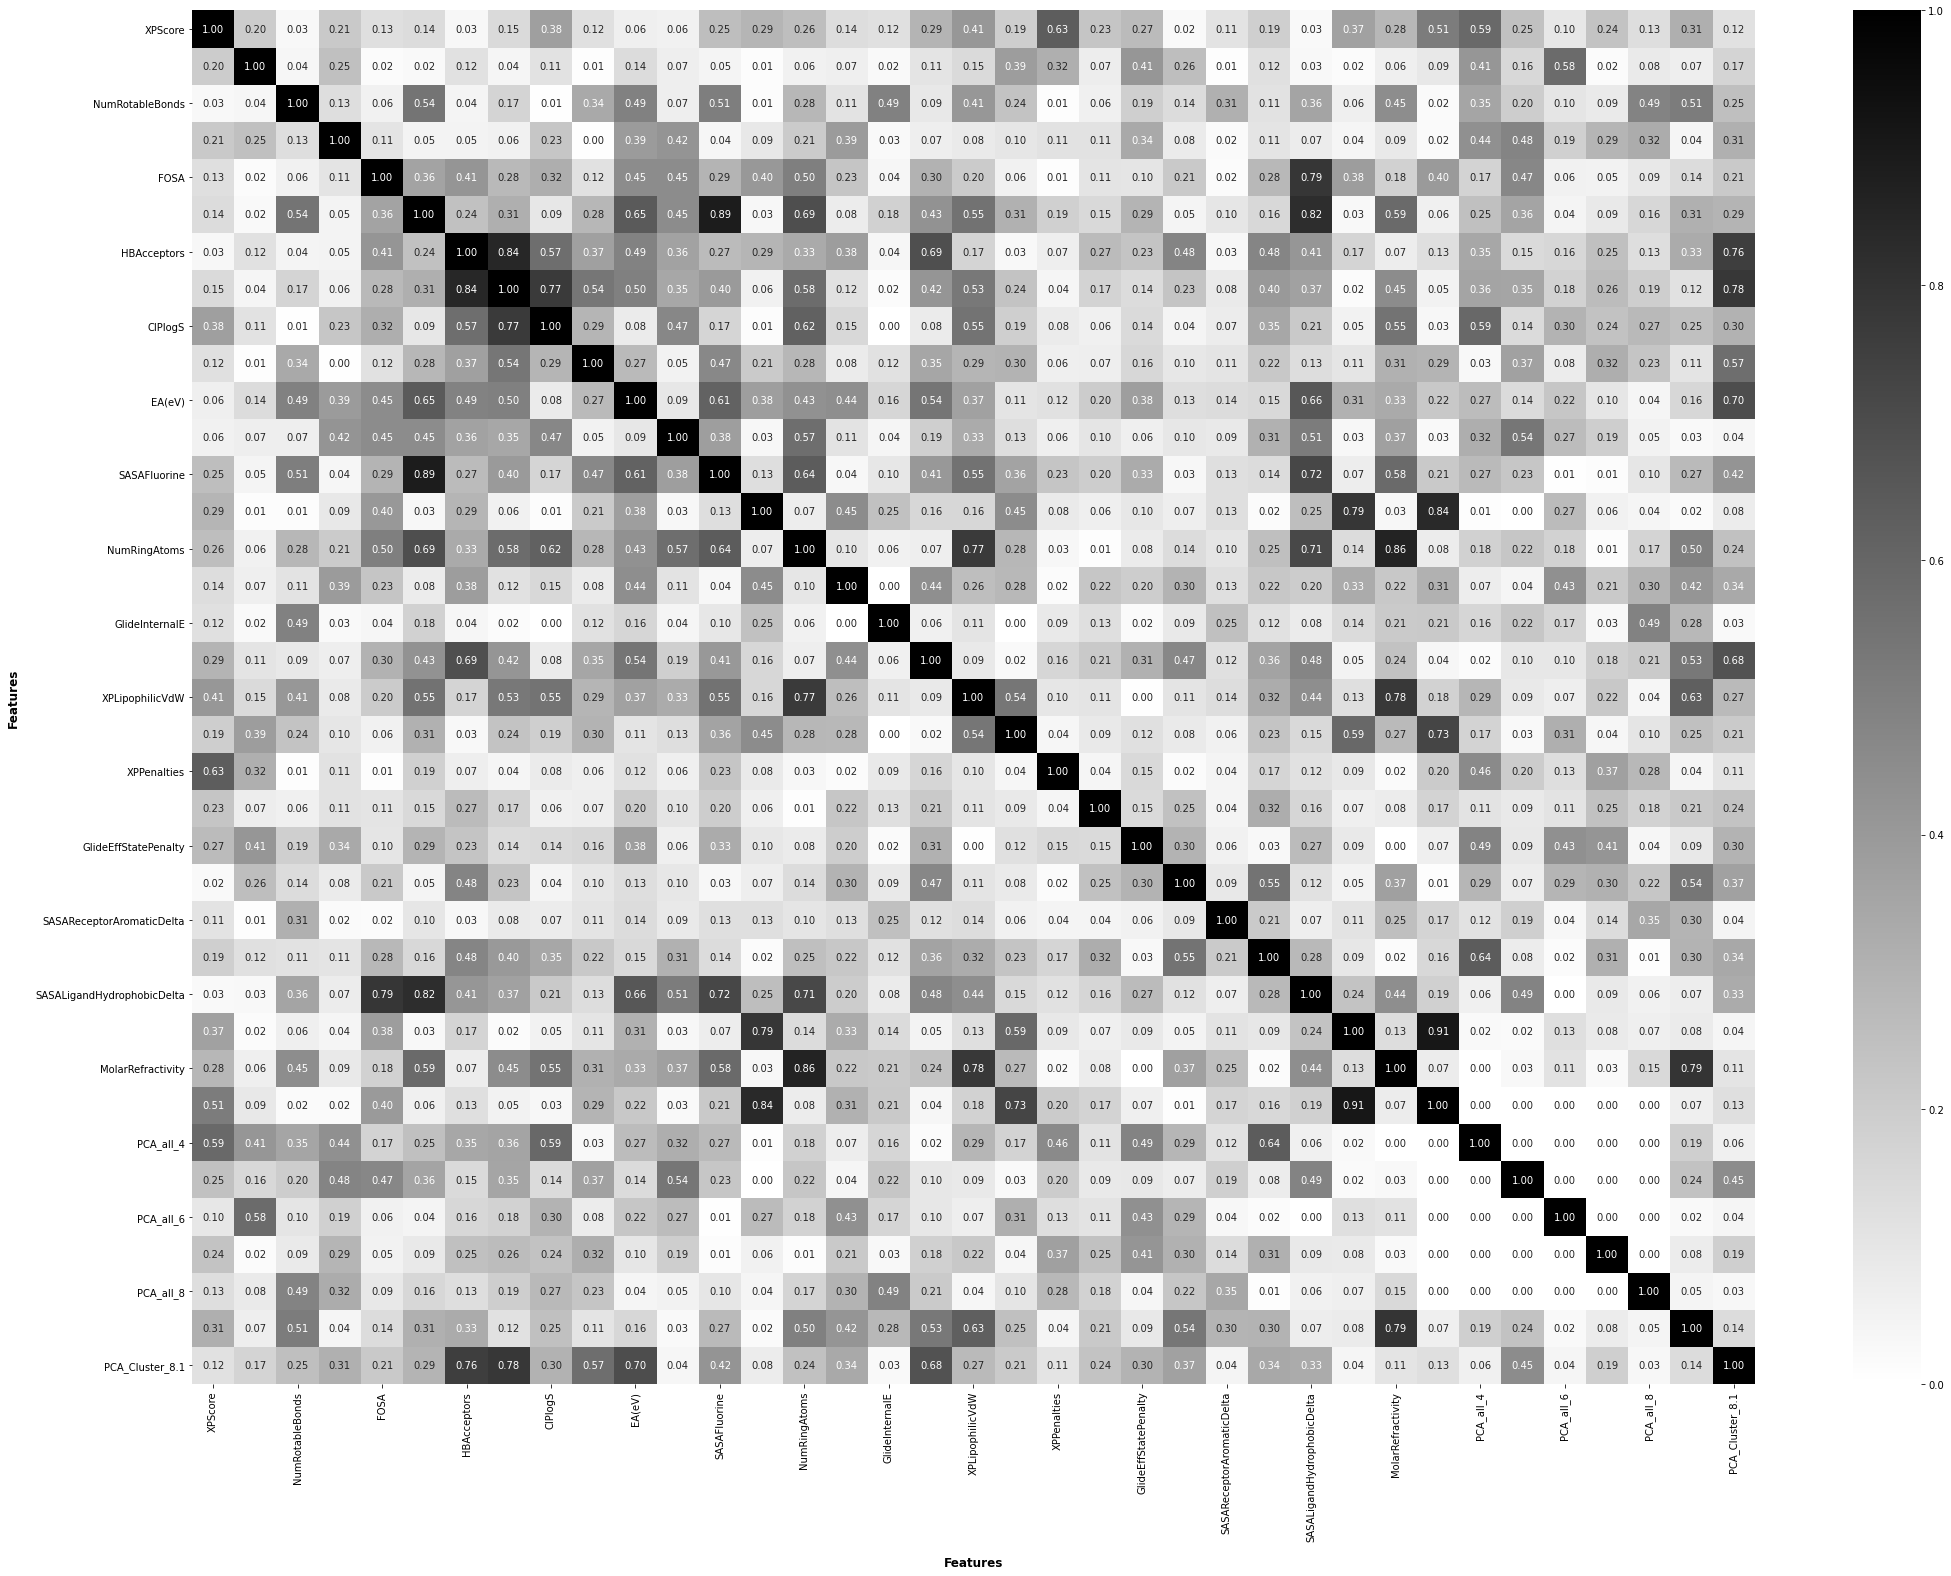

In [ ]:
fig_22, ax = features.draw_correlation()
fig_22.set_size_inches(30, 22)
fig_22.tight_layout()

We now want to know how our algorithms' performance changes as we increase/decrease the amount of features used to train them, so we can learn an approximate number of features that would be optimal to maximize the performance of each type of algorithm. For that purpose, we will use a sequential feature selection algorithm, which will add features to the algorithm one by one. Each addition will be made based on the feature that maximizes the increase in the cross-validated score compared to the previous step.

In [ ]:
fig_1.savefig('fig1.png')
fig_2.savefig('fig2.png')
fig_3.savefig('fig3.png')
fig_4.savefig('fig4.png')
fig_5.savefig('fig5.png')
fig_6.savefig('fig6.png')
fig_7.savefig('fig7.png')
fig_8.savefig('fig8.png')
fig_9.savefig('fig9.png')
fig_10.savefig('fig10.png')
fig_11.savefig('fig11.png')
fig_12.savefig('fig12.png')
fig_13.savefig('fig13.png')
fig_14.savefig('fig14.png')
fig_15.savefig('fig15.png')
fig_16.savefig('fig16.png')
fig_17.savefig('fig17.png')
fig_18.savefig('fig18.png')
fig_19.savefig('fig19.png')
fig_20.savefig('fig20.png')
fig_21.savefig('fig21.png')
fig_22.savefig('fig22.png')

In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, SVR
from sklearn.cross_decomposition import PLSRegression
from xgboost import XGBRegressor, XGBClassifier

## Regressor performance as function of feature number.

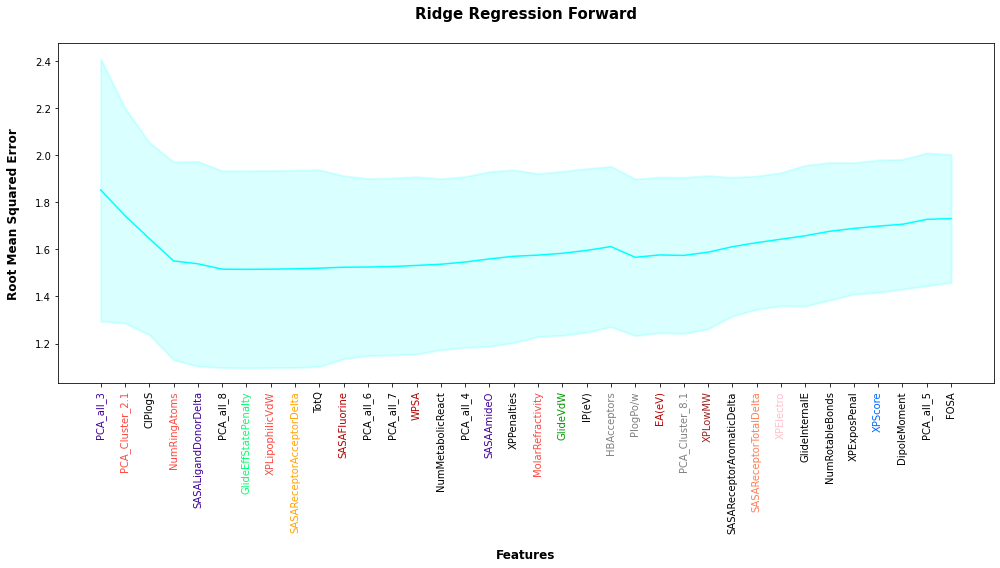

In [ ]:
fig_23, ax = features.draw_sfs(Ridge(), direction='forward', scoring='neg_root_mean_squared_error')
ax.set_title('Ridge Regression Forward', fontsize=15, fontweight='bold', pad=25)
fig_23.set_size_inches(14, 8)
fig_23.tight_layout()

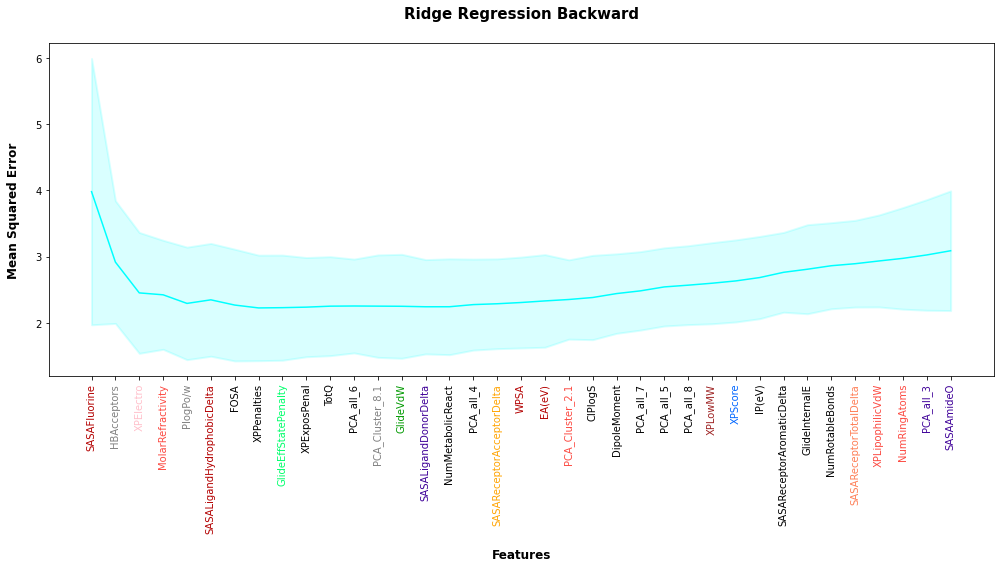

In [ ]:
fig_29, ax = features.draw_sfs(Ridge(), direction='backward', scoring='neg_root_mean_squared_error')
ax.set_title('Ridge Regression Backward', fontsize=15, fontweight='bold', pad=25)
fig_29.set_size_inches(14, 8)
fig_29.tight_layout()

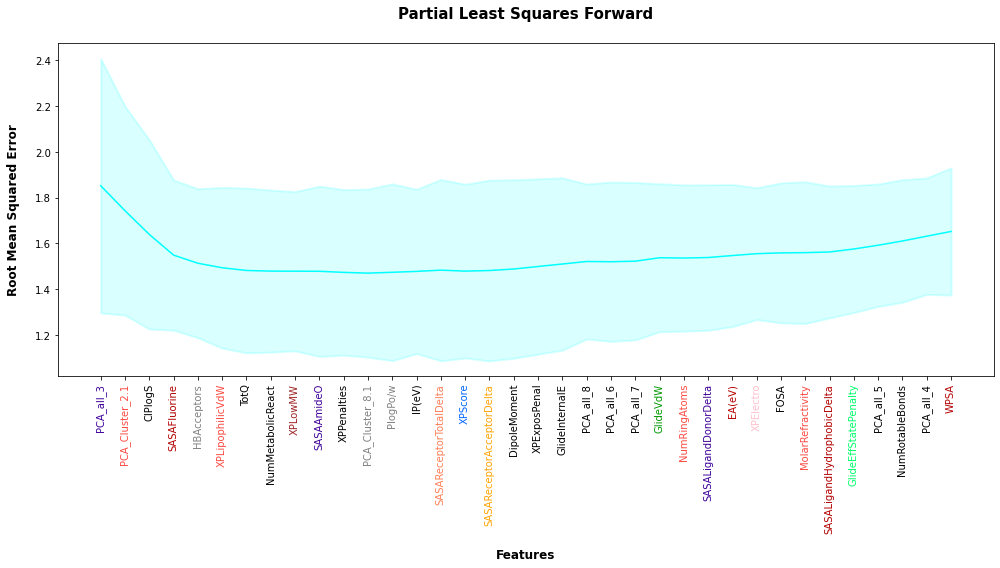

In [ ]:
fig_24, ax = features.draw_sfs(PLSRegression(), direction='forward', scoring='neg_root_mean_squared_error')
ax.set_title('Partial Least Squares Forward', fontsize=15, fontweight='bold', pad=25)
fig_24.set_size_inches(14, 8)
fig_24.tight_layout()

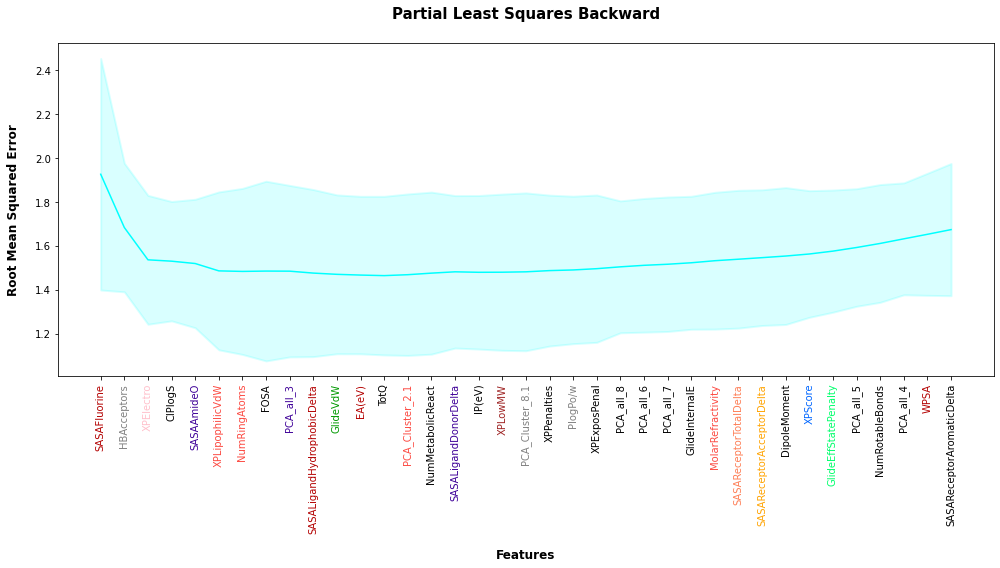

In [ ]:
fig_30, ax = features.draw_sfs(PLSRegression(), direction='backward', scoring='neg_root_mean_squared_error')
ax.set_title('Partial Least Squares Backward', fontsize=15, fontweight='bold', pad=25)
fig_30.set_size_inches(14, 8)
fig_30.tight_layout()

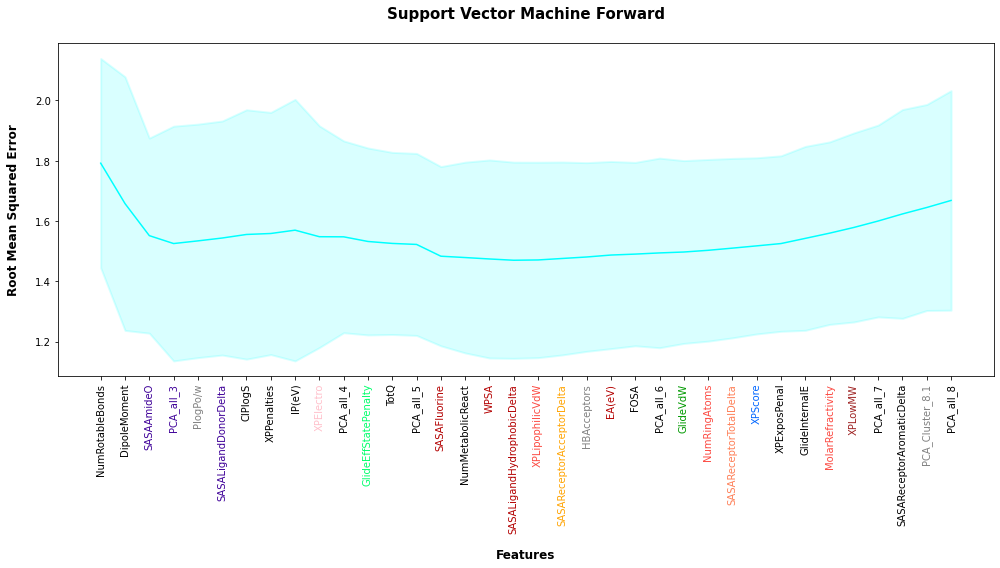

In [ ]:
fig_25, ax = features.draw_sfs(SVR(), direction='forward', scoring='neg_root_mean_squared_error')
ax.set_title('Support Vector Machine Forward', fontsize=15, fontweight='bold', pad=25)
fig_25.set_size_inches(14, 8)
fig_25.tight_layout()

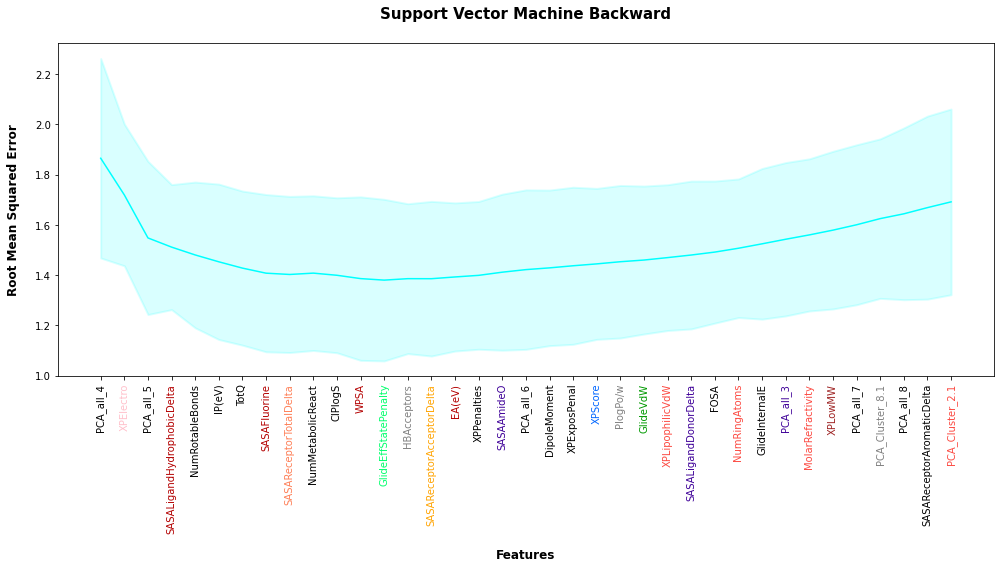

In [ ]:
fig_31, ax = features.draw_sfs(SVR(), direction='backward', scoring='neg_root_mean_squared_error')
ax.set_title('Support Vector Machine Backward', fontsize=15, fontweight='bold', pad=25)
fig_31.set_size_inches(14, 8)
fig_31.tight_layout()

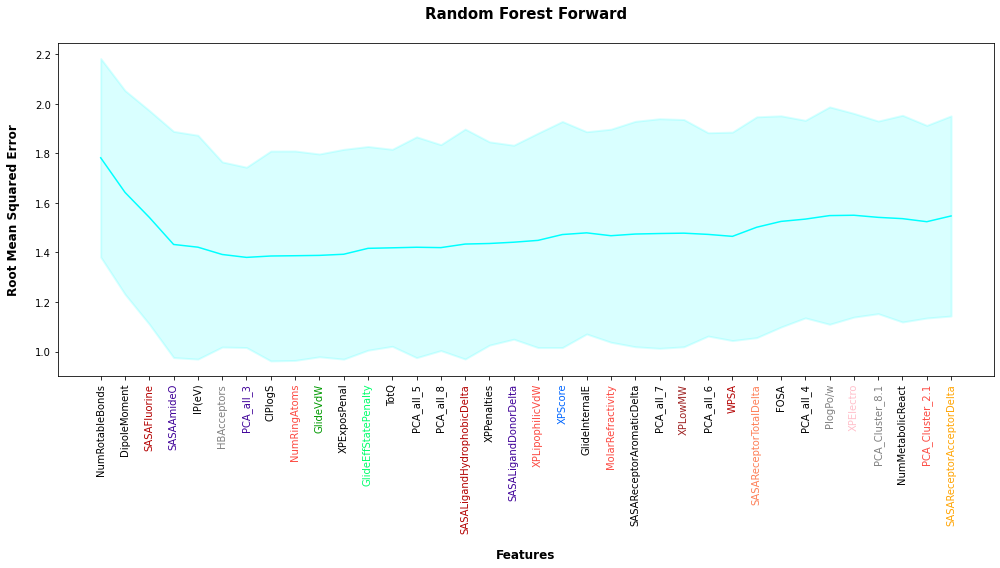

In [ ]:
fig_26, ax = features.draw_sfs(RandomForestRegressor(), direction='forward', scoring='neg_root_mean_squared_error')
ax.set_title('Random Forest Forward', fontsize=15, fontweight='bold', pad=25)
fig_26.set_size_inches(14, 8)
fig_26.tight_layout()

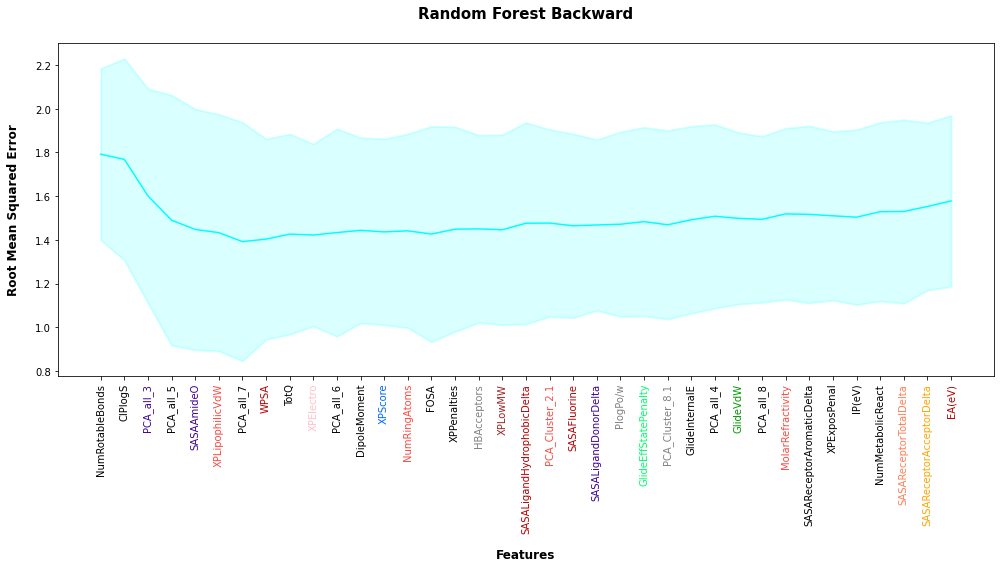

In [ ]:
fig_32, ax = features.draw_sfs(RandomForestRegressor(), direction='backward', scoring='neg_root_mean_squared_error')
ax.set_title('Random Forest Backward', fontsize=15, fontweight='bold', pad=25)
fig_32.set_size_inches(14, 8)
fig_32.tight_layout()

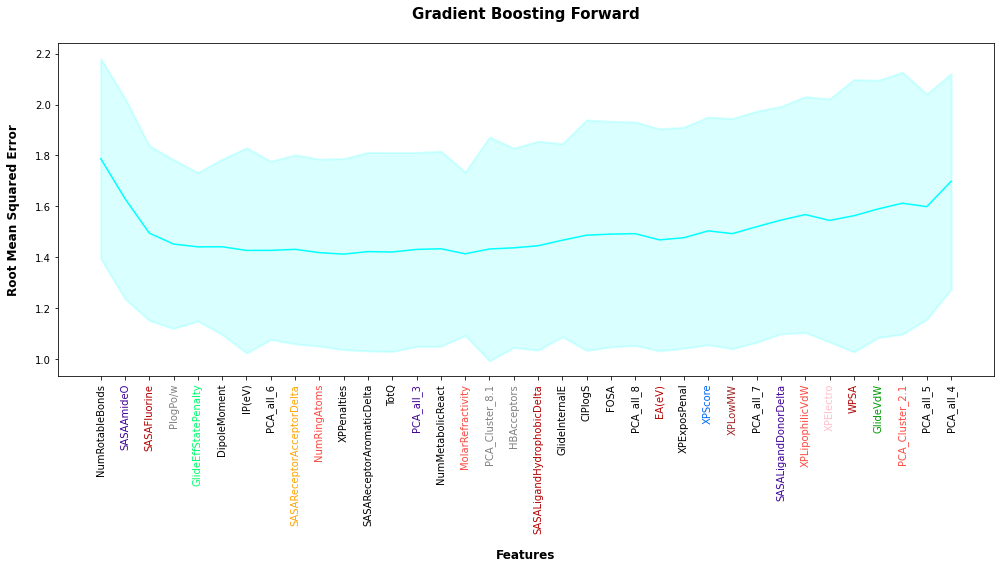

In [ ]:
fig_27, ax = features.draw_sfs(GradientBoostingRegressor(), direction='forward', scoring='neg_root_mean_squared_error')
ax.set_title('Gradient Boosting Forward', fontsize=15, fontweight='bold', pad=25)
fig_27.set_size_inches(14, 8)
fig_27.tight_layout()

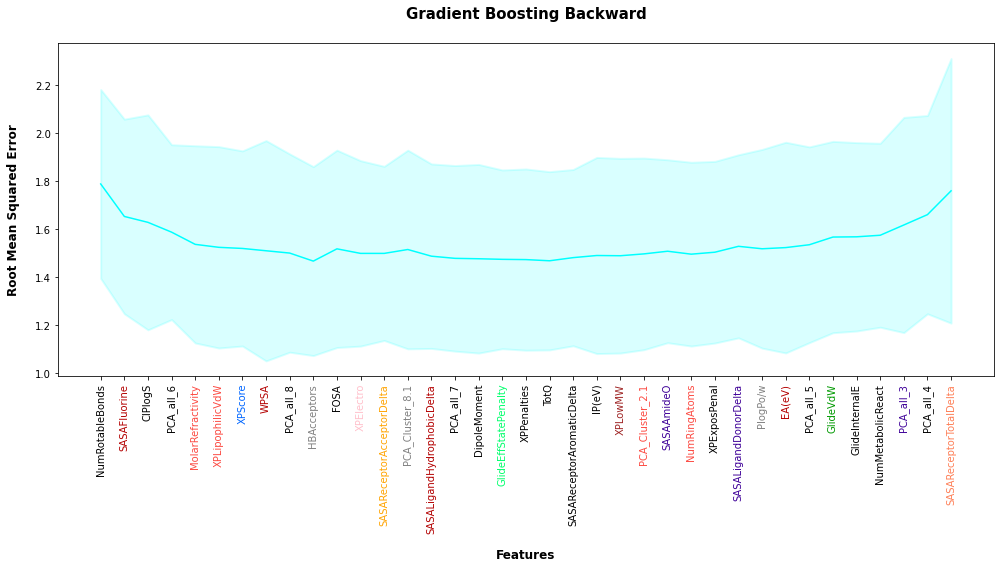

In [ ]:
fig_33, ax = features.draw_sfs(GradientBoostingRegressor(), direction='backward', scoring='neg_root_mean_squared_error')
ax.set_title('Gradient Boosting Backward', fontsize=15, fontweight='bold', pad=25)
fig_33.set_size_inches(14, 8)
fig_33.tight_layout()

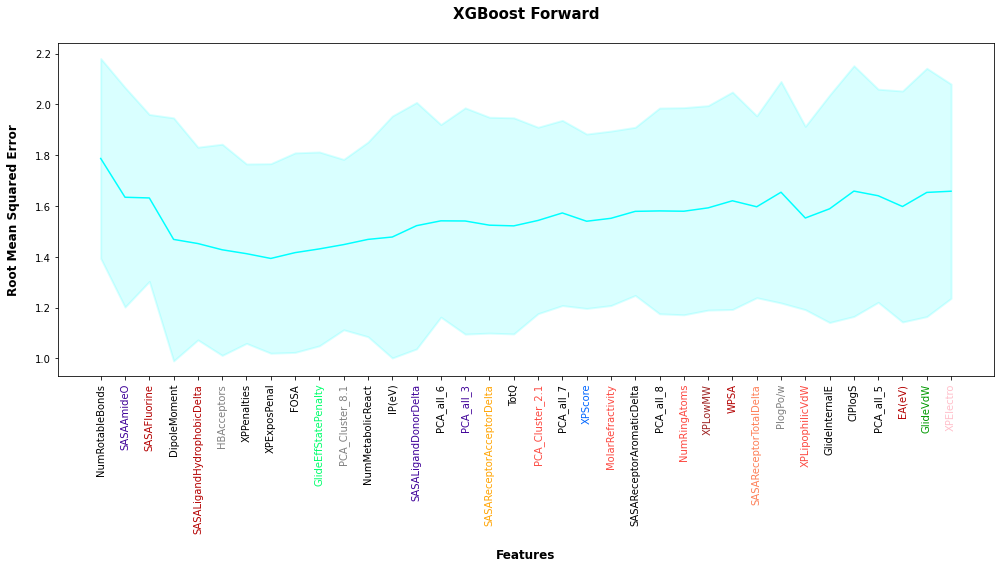

In [ ]:
fig_28, ax = features.draw_sfs(XGBRegressor(), direction='forward', scoring='neg_root_mean_squared_error')
ax.set_title('XGBoost Forward', fontsize=15, fontweight='bold', pad=25)
fig_28.set_size_inches(14, 8)
fig_28.tight_layout()

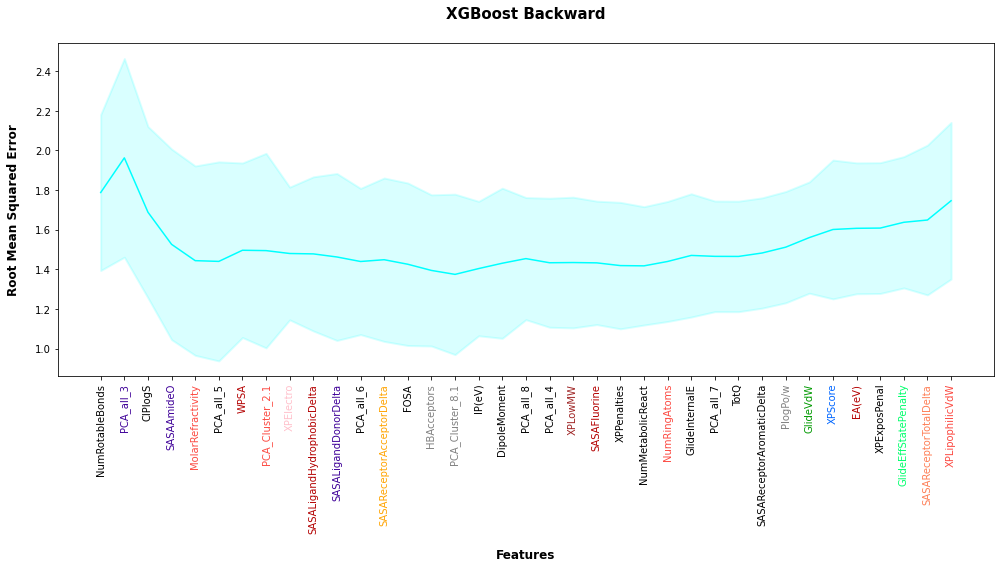

In [ ]:
fig_34, ax = features.draw_sfs(XGBRegressor(), direction='backward', scoring='neg_root_mean_squared_error')
ax.set_title('XGBoost Backward', fontsize=15, fontweight='bold', pad=25)
fig_34.set_size_inches(14, 8)
fig_34.tight_layout()

In [ ]:
fig_23.savefig('Images/fig23.png')
fig_24.savefig('Images/fig24.png')
fig_25.savefig('Images/fig25.png')
fig_26.savefig('Images/fig26.png')
fig_27.savefig('Images/fig27.png')
fig_28.savefig('Images/fig28.png')
fig_29.savefig('Images/fig29.png')
fig_30.savefig('Images/fig30.png')
fig_31.savefig('Images/fig31.png')
fig_32.savefig('Images/fig32.png')
fig_33.savefig('Images/fig33.png')
fig_34.savefig('Images/fig34.png')
fig_35.savefig('Images/fig35.png')

In [ ]:
PCA_features = [feat for feat in features.feature_names if feat.startswith('PCA')]

In [ ]:
features.feature_df[PCA_features]

PCA_all_3  PCA_all_4  ...  PCA_Cluster_2.1  PCA_Cluster_8.1
0     3.602475  -0.380513  ...        -1.353559        -1.277367
1    -0.266598  -0.834692  ...        -1.425258         1.711398
2    -0.266598  -0.834692  ...        -1.425258         1.711398
3     0.075211  -0.022632  ...        -0.962046         0.650465
4    -0.267194   0.132978  ...        -1.114351         1.749319
..         ...        ...  ...              ...              ...
171   4.115276   0.104343  ...         2.316236         1.310289
172   4.084247  -0.616827  ...         2.090393         1.508065
173   7.294980  -0.197340  ...         2.077592         1.240471
174   6.507637   0.366071  ...         2.915173         1.359641
175  -0.951932  -0.820652  ...         1.421025         0.753061

[176 rows x 8 columns]

In [ ]:
other_features = ['Title', 'SMILES', 'ln(IC50 (M))', 'IC50_clf', 'ClusterIdx'] + [feat for feat in features.feature_names if not feat.startswith('PCA')]

In [ ]:
non_standard_df = pd.concat([data[other_features], features.feature_df[PCA_features]], axis=1)

In [ ]:
standard_df = pd.concat([data[['Title', 'SMILES', 'ln(IC50 (M))', 'IC50_clf', 'ClusterIdx']], features.feature_df], axis=1)

In [ ]:
non_standard_df.to_csv('/content/NonStandardizedDF.csv', index=False)
standard_df.to_csv('/content/StandardizedDF.csv', index=False)

In [ ]:
!mkdir /content/data

In [ ]:
!mv NonStandardizedDF.csv /content/data/
!mv StandardizedDF.csv /content/data

In [ ]:
!zip -r /content/data_dfs.zip /content/data/

  adding: content/data/ (stored 0%)
  adding: content/data/NonStandardizedDF.csv (deflated 59%)
  adding: content/data/StandardizedDF.csv (deflated 65%)
